# Machine Learning NLP Binary

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import random as rd
from matplotlib.ticker import FormatStrFormatter
from collections import defaultdict
import re
import string

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import make_column_selector

from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop

from scipy.stats import uniform, loguniform, randint

import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, Embedding, LSTM, Dropout, Activation, Conv1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Flatten, concatenate, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.python.keras.layers import Layer

import transformers

from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope

import gc

In [3]:
from script_preprocessing_nlp import *

✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


In [4]:
data = pd.read_csv('/kaggle/input/comments-orangebank/TrustPilot_data.csv')
data = data[~data.text.isnull()].reset_index(drop=True)
data['sentiment'] = data.star.map({5:1,4:1,3:0,2:0,1:0})
data

,title,date,star,text,sentiment
0,Excellent,2021-01-02T10:01:14+00:00,5,"Très bien, service parfait et rapide.",1
1,"Bonjour,",2021-01-01T14:54:01+00:00,5,"Bonjour,J'étais bien reçue par Monsieur Antony...",1
2,Bonjour.compte bloqué,2020-12-30T20:29:03+00:00,1,"Bonjour.compte bloqué. .carte ,retrait,viremen...",0
3,ORANGE BANK ou la banque de DINGO,2020-12-30T19:22:00+00:00,1,ORANGE BANK ou votre interlocueteur est le ROB...,0
4,Très pratique,2020-12-30T17:16:37+00:00,5,"Très pratique, je peux à tout moment bloquer l...",1
...,...,...,...,...,...
393,Impossible d'ouvrir un compte,2018-03-19T18:27:43Z,1,Impossible d'ouvrir un compte. Bugs en plein m...,0
394,Attention Orange bank fait du phishing,2018-02-09T10:34:09Z,1,"Attention Orange bank fait du fishing, ils réc...",0
395,Bon service mais service client lent,2018-02-04T22:45:45Z,4,Après plusieurs refus d'ouverture d'un compte ...,1
396,Bugs très graves,2018-01-26T09:03:35Z,1,Bugs très graves de l’appli. Souvent on ne peu...,0


# Metrics

In [5]:
# help function

def calcul_metric_binary(y_true_, y_pred, print_results):
    try: # try to pass y_true_ to type numpy
        y_true = y_true_.values.copy()
    except:
        y_true = y_true_.copy()
        
    report = classification_report(y_true.reshape(-1), np.where(y_pred<0.5,0,1).reshape(-1), digits = 4, output_dict = True)
    acc = np.round(report['accuracy'],4)
    f1 = np.round(report['1']['f1-score'],4)
    recall = np.round(report['1']['recall'],4)
    precision = np.round(report['1']['precision'],4)
    #roc_auc = np.round(roc_auc_score(y_true.values, np.where(y_pred<0.5,0,1)),4)
    fp_rate, tp_rate, thresholds = roc_curve(y_true.reshape(-1), y_pred.reshape(-1))
    roc_auc = np.round(auc(fp_rate, tp_rate),4)
    
    if print_results:
        print('\nCross validation score :')
        print()
        print('roc_auc =', roc_auc)
        print('precision 1 =', precision)
        print('recall 1 =', recall)
        print('f1 score 1 =',f1)
        print()
        print(classification_report(y_true.reshape(-1), np.where(y_pred<0.5,0,1).reshape(-1), digits = 3))
    
    return acc, f1, recall, precision, roc_auc

def roc(y_true, y_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    return fpr, tpr

# Help functions and GridSearch functions

In [6]:
def compute_dict_class_weight(y, class_weight, objective):
    if class_weight == "balanced":
        if ('binary' in objective) or (y.shape[1] == 1 and 'classification' in objective):
            weights = compute_class_weight(class_weight='balanced', classes=np.unique(y.reshape(-1)), y=y.reshape(-1))
            return dict(zip(np.unique(y.reshape(-1)), weights))
        else:
            return None
    else:
        return None


def optimization_gridsearch(x, y, model, distributions, time_limit_per_model, nfolds, scoring, objective):
    """ gridsearch function for sklearn model with time integrated """

    print_details = False

    n_iter = 1

    start, last_call = time.perf_counter(), time.perf_counter()

    df_results = pd.DataFrame()
    df_all_results = pd.DataFrame()
    best_n_iter = 0

    while time.perf_counter() - start < time_limit_per_model:

        clf = RandomizedSearchCV(model, distributions, random_state=None, n_iter=n_iter, cv=nfolds, scoring=scoring)
        search = clf.fit(x, y)

        approx_time = (time.perf_counter() - last_call) / n_iter
        if print_details:
            print('time :', approx_time * n_iter, 'and n_iter :', n_iter)
            print(search.best_params_)
            print(search.best_score_)
            print()
        if n_iter > best_n_iter:
            best_approx_time = approx_time
            best_n_iter = n_iter

        n_iter = int((time_limit_per_model - (time.perf_counter() - start)) / best_approx_time / 3)
        last_call = time.perf_counter()

        df_results = pd.concat([df_results, pd.DataFrame(clf.cv_results_)], axis=0).reset_index(drop=True)

        if n_iter < 3 and time.perf_counter() - start > time_limit_per_model * 0.8:
            break

        if n_iter < 1:
            break

    print('  Total time :', np.round(time.perf_counter() - start, 3), 'and n_iter :', len(df_results))

    df_all_results = pd.concat([df_all_results, df_results])

    best_mean = np.mean(df_results.mean_test_score)
    best_score = np.max(df_results.mean_test_score)
    if print_details:
        plt.hist(df_results.mean_test_score)
        plt.show()

    return df_all_results


class GridSearch:

    def __init__(self, model, hyper_params):
        self.model = model
        self.model_2 = model
        self.hyper_params = hyper_params

    def train(self, x, y, nfolds=5, scoring='accuracy', verbose=0, time_limit_per_model=60, objective='binary'):
        self.df_all_results = optimization_gridsearch(x, y, self.model, self.hyper_params, time_limit_per_model, nfolds,
                                                      scoring, objective)
        self.index_best_score = self.df_all_results.mean_test_score.argmax()

    def show_distribution_score(self):
        plt.hist(self.df_all_results.mean_test_score)
        plt.show()

    def best_params(self, print_result=False):
        params = self.df_all_results.loc[self.index_best_score, 'params']
        print_params = params.copy()
        if print_result:
            if 'vect__text__tfidf__stop_words' in params.keys() and params['vect__text__tfidf__stop_words'] is not None:
                print_params['vect__text__tfidf__stop_words'] = True
            if 'vect__tfidf__stop_words' in params.keys() and params['vect__tfidf__stop_words'] is not None:
                print_params['vect__tfidf__stop_words'] = True
            print('Best parameters: ', print_params)
        return params

    def best_score(self, print_result=False):
        score = self.df_all_results.loc[self.index_best_score, 'mean_test_score']
        if print_result:
            print('Mean cross-validated score of the best_estimator: ', np.round(score, 4))
        return score

    def best_estimator(self, objective):
        if 'catboost' in str(type(self.model_2)):
            return cat.CatBoostClassifier(
                random_state=self.model_2.get_param('random_state'),
                class_weights=self.model_2.get_param('class_weights'),
                verbose=False,
                bootstrap_type='Bernoulli',
                **self.best_params()
            )
        else:
            return self.model_2.set_params(**self.best_params())

    def get_grid(self, sort_by='mean_test_score'):
        return self.df_all_results[['mean_fit_time', 'params', 'mean_test_score', 'std_test_score']].sort_values(
            by=sort_by, ascending=False).reset_index(drop=True)


class GridSearch_NN:

    def __init__(self, Model_NN, hyper_params):
        self.Model_NN = Model_NN
        self.hyper_params = hyper_params

    def optimise(self, params):

        self.Model_NN.initialize_params(self.x, self.y, params)

        print(self.Model_NN.p)

        oof_val = np.zeros((self.y.shape[0], self.y.shape[1]))
        start = time.perf_counter()

        for n, (tr, te) in enumerate(KFold(n_splits=self.nfolds,
                                           random_state=self.Model_NN.seed,
                                           shuffle=True).split(self.y)):

            if isinstance(self.x, dict):
                x_tr, x_val = {}, {}
                for col in self.x.keys():
                    x_tr[col], x_val[col] = self.x[col][tr], self.x[col][te]
                y_tr, y_val = self.y.values[tr], self.y.values[te]
            elif isinstance(self.x, list):
                x_tr, x_val = [], []
                for col in range(len(self.x)):
                    x_tr.append(self.x[col][tr])
                    x_val.append(self.x[col][te])
                y_tr, y_val = self.y.values[tr], self.y.values[te]
            else:
                x_tr, x_val = self.x.values[tr], self.x.values[te]
                y_tr, y_val = self.y.values[tr], self.y.values[te]

            model = self.Model_NN.model()

            if self.scoring == 'accuracy':
                monitor = 'accuracy'
            else:
                monitor = 'loss'

            rlr = ReduceLROnPlateau(monitor='val_' + monitor, factor=0.1, patience=3,
                                    verbose=0, epsilon=1e-4, mode='auto', min_lr=1e-4)

            # ckp = ModelCheckpoint(f'model_{n}.hdf5', monitor = 'val_loss', verbose = 0,
            #                      save_best_only = True, save_weights_only = True, mode = 'min')

            es = EarlyStopping(monitor='val_' + monitor, min_delta=0.0001, patience=4, mode='auto',
                               baseline=None, restore_best_weights=True, verbose=0)

            history = model.fit(x_tr, y_tr, validation_data=(x_val, y_val),
                                epochs=60, batch_size=16,
                                class_weight=compute_dict_class_weight(y_tr, self.Model_NN.class_weight,
                                                                       self.Model_NN.objective),
                                callbacks=[rlr, es], verbose=0)

            hist = pd.DataFrame(history.history)

            if 'binary_proba' in self.Model_NN.objective:
                oof_val[te, :] = model.predict(x_val)
            else:
                oof_val[te, :] = np.argmax(model.predict(x_val), axis=1).reshape(-1, 1)

            self.total_epochs += len(history.history['val_loss'][:-5])

            K.clear_session()
            del model, history, hist
            d = gc.collect()

        metrics = []
        oof_val = np.where(oof_val > 0.5, 1, 0).reshape(-1)
        if 'f1' in self.scoring:
            metrics.append(-f1_score(self.y.values.reshape(-1), oof_val))
        elif 'recall' in self.scoring:
            metrics.append(-recall_score(self.y.values.reshape(-1), oof_val))
        elif 'precision' in self.scoring:
            metrics.append(-precision_score(self.y.values.reshape(-1), oof_val))
        elif 'roc' in self.scoring or 'auc' in self.scoring:
            metrics.append(-roc_auc_score(self.y.values.reshape(-1), oof_val))
        else:
            metrics.append(-accuracy_score(self.y.values.reshape(-1), oof_val))

        score = -np.mean(metrics)
        print('oof_val score', self.scoring, 'Metric', score)

        if 'hidden_units' in self.Model_NN.p.keys():
            self.list_hist[len(self.Model_NN.p['hidden_units']) - 1].append(score)
        else:
            self.list_hist[0].append(score)
        self.df_all_results['mean_fit_time'].append(time.perf_counter() - start)
        self.df_all_results['params'].append(params)
        self.df_all_results['mean_test_score'].append(score)
        self.df_all_results['std_test_score'].append(0)  # just 0

        return np.mean(metrics)

    def train(self, x_, y_, nfolds=5, scoring='accuracy', verbose=0, time_limit_per_model=60,
              name_model='SimpleNeuralNetwork'):
        self.x = x_  # .copy().reset_index(drop=True)
        self.y = y_  # .copy().reset_index(drop=True)
        self.nfolds = nfolds
        self.scoring = scoring
        self.df_all_results = {'mean_fit_time': [], 'params': [], 'mean_test_score': [], 'std_test_score': []}
        self.list_hist = [[] for name in self.hyper_params.keys() if 'hidden_unit' in name]
        if len(self.list_hist) == 0:
            self.list_hist = [[]]
        self.total_epochs = 0
        trials = Trials()

        self.hopt = fmin(fn=self.optimise,
                         space=self.hyper_params,
                         algo=tpe.suggest,
                         max_evals=100,
                         timeout=time_limit_per_model,
                         trials=trials,
                         )

        self.df_all_results = pd.DataFrame(self.df_all_results)
        self.df_all_results['model'] = name_model
        self.index_best_score = self.df_all_results.mean_test_score.argmax()
        self.mean_epochs = int(self.total_epochs / self.nfolds) + 1

    def show_distribution_score(self):
        rows, cols = 1, 3
        fig, ax = plt.subplots(rows, cols, figsize=(50, 20))

        for row in range(rows):
            for col in range(cols):
                if row * cols + col + 1 <= len(self.list_hist) and len(self.list_hist[row * cols + col]) > 0:
                    ax[col].hist(self.list_hist[row * cols + col])
                    for tick in ax[col].xaxis.get_major_ticks():
                        tick.label.set_fontsize(30)
        plt.show()

    def best_params(self, print_result=False):
        params = self.df_all_results.loc[self.index_best_score, 'params']
        if print_result:
            print('Best parameters: ', params)
        return params

    def best_score(self, print_result=False):
        score = self.df_all_results.loc[self.index_best_score, 'mean_test_score']
        if print_result:
            print('Mean cross-validated score of the best_estimator: ', np.round(score, 4))
        return score

    def best_estimator(self, objective):
        self.Model_NN.initialize_params(self.x, self.y, self.best_params())

        model = self.Model_NN.model()

        if self.scoring == 'accuracy':
            monitor = 'accuracy'
        else:
            monitor = 'loss'
        rlr = ReduceLROnPlateau(monitor='val_' + monitor, factor=0.1, patience=3,
                                verbose=1, epsilon=1e-4, mode='auto', min_lr=1e-4)

        # ckp = ModelCheckpoint(f'model_{n}.hdf5', monitor = 'val_loss', verbose = 0,
        #                      save_best_only = True, save_weights_only = True, mode = 'min')

        es = EarlyStopping(monitor='val_' + monitor, min_delta=0.0001, patience=5, mode='auto',
                           baseline=None, restore_best_weights=True, verbose=0)

        for n, (tr, te) in enumerate(KFold(n_splits=10,
                                           random_state=self.Model_NN.seed,
                                           shuffle=True).split(self.y)):

            if isinstance(self.x, dict):
                x_tr, x_val = {}, {}
                for col in self.x.keys():
                    x_tr[col], x_val[col] = self.x[col][tr], self.x[col][te]
                y_tr, y_val = self.y.values[tr], self.y.values[te]
            elif isinstance(self.x, list):
                x_tr, x_val = [], []
                for col in range(len(self.x)):
                    x_tr.append(self.x[col][tr])
                    x_val.append(self.x[col][te])
                y_tr, y_val = self.y.values[tr], self.y.values[te]
            else:
                x_tr, x_val = self.x.values[tr], self.x.values[te]
                y_tr, y_val = self.y.values[tr], self.y.values[te]

            history = model.fit(x_tr, y_tr, validation_data=(x_val, y_val),
                                epochs=60, batch_size=16,
                                class_weight=compute_dict_class_weight(y_tr, self.Model_NN.class_weight,
                                                                       self.Model_NN.objective),
                                callbacks=[rlr, es], verbose=0)
            break  # best_model train on only one validation
        return model

    def get_grid(self, sort_by='mean_test_score'):
        return self.df_all_results[['mean_fit_time', 'params', 'mean_test_score', 'std_test_score']].sort_values(
            by=sort_by, ascending=False).reset_index(drop=True)

# Validation

In [7]:
class Validation:

    def __init__(self, objective, seed=15, is_NN=False, name=None, class_weight=None):
        self.seed = seed
        self.objective = objective
        self.is_NN = is_NN
        self.name = name
        self.class_weight = class_weight

    def fit(self, model, x, y, nfolds=5, scoring='accuracy', print_result=False):

        self.oof_val = np.zeros((len(y),))
        self.fold_id = np.zeros((len(y),))

        if self.is_NN:
            # weights = model.get_weights()
            # model.save_weights('model.h5')
            total_epochs = 0

            kf = KFold(n_splits=nfolds, shuffle=True, random_state=self.seed)

            for num_fold, (train_index, val_index) in enumerate(kf.split(y)):
                if isinstance(x, dict):
                    x_train, x_val = {}, {}
                    for col in x.keys():
                        x_train[col], x_val[col] = x[col][train_index], x[col][val_index]
                    y_train, y_val = y.values[train_index], y.values[val_index]
                elif isinstance(x, list):
                    x_train, x_val = [], []
                    for col in range(len(x)):
                        x_train.append(x[col][train_index])
                        x_val.append(x[col][val_index])
                    y_train, y_val = y.values[train_index], y.values[val_index]
                else:
                    try:
                        x_train, x_val = x.values[train_index], x.values[val_index]
                    except:
                        x_train, x_val = x[train_index], x[val_index]
                    try:
                        y_train, y_val = y.values[train_index], y.values[val_index]
                    except:
                        y_train, y_val = y[train_index], y[val_index]

                K.clear_session()
                # model = model.set_weights(weights)
                # model.load_weights('model.h5')

                model_nn = model()

                if scoring == 'accuracy':
                    monitor = 'accuracy'
                else:
                    monitor = 'loss'
                rlr = ReduceLROnPlateau(monitor='val_' + monitor, factor=0.1, patience=3,
                                        verbose=1, epsilon=1e-4, mode='auto', min_lr=1e-4)  ########## !!!!!!!!!!!!

                # ckp = ModelCheckpoint(f'model_{n}.hdf5', monitor = 'val_loss', verbose = 0,
                #                      save_best_only = True, save_weights_only = True, mode = 'min')

                es = EarlyStopping(monitor='val_' + monitor, min_delta=0.0001, patience=4, mode='auto',
                                   baseline=None, restore_best_weights=True, verbose=0)

                train_history = model_nn.fit(x_train, y_train,
                                             validation_data=(x_val, y_val),
                                             class_weight=compute_dict_class_weight(y_train, self.class_weight,
                                                                                    self.objective),
                                             epochs=50, batch_size=16, verbose=1, callbacks=[rlr, es])

                print('Kfold #', num_fold, ' : train', monitor, '=', train_history.history[monitor][-5], ' and val',
                      monitor, '=', train_history.history['val_' + monitor][-5])
                total_epochs += len(train_history.history[monitor][:-5])

                if 'binary_proba' in self.objective:
                    self.oof_val[val_index] = model_nn.predict(x_val).reshape(-1)
                else:
                    self.oof_val[val_index] = np.argmax(model_nn.predict(x_val), axis=1).reshape(-1)
                self.fold_id[val_index] = num_fold

        else:
            kf = KFold(n_splits=nfolds, shuffle=True, random_state=self.seed)

            for num_fold, (train_index, val_index) in enumerate(kf.split(x)):
                try:
                    x_train, x_val = x.values[train_index], x.values[val_index]
                except:
                    x_train, x_val = x[train_index], x[val_index]
                try:
                    y_train, y_val = y.values[train_index], y.values[val_index]
                except:
                    y_train, y_val = y[train_index], y[val_index]

                model.fit(x_train, y_train)

                if 'binary_proba' in self.objective:
                    self.oof_val[val_index] = model.predict_proba(x_val)[:, 1].reshape(x_val.shape[0], )
                else:
                    self.oof_val[val_index] = model.predict(x_val).reshape(x_val.shape[0], )
                self.fold_id[val_index] = num_fold

        self.acc_val, self.f1_val, self.recall_val, self.pre_val, self.roc_auc_val = calcul_metric_binary(y,
                                                                                                          self.oof_val,
                                                                                                          print_result)
        self.fpr, self.tpr = roc(y.values, self.oof_val)

        del x_train, x_val, y_train, y_val, model

    def get_cv_prediction(self):
        return self.fold_id, self.oof_val

    def get_scores(self):
        return self.acc_val, self.f1_val, self.recall_val, self.pre_val, self.roc_auc_val

    def get_roc(self):
        return self.fpr, self.tpr

# Prediction

In [8]:
class Prediction:

    def __init__(self, objective, name=None, is_NN=False, class_weight=None):
        self.objective = objective
        self.name = name
        self.is_NN = is_NN
        self.class_weight = class_weight

    def fit(self, model, x, y=None, print_result=False):

        if self.is_NN:
            if 'pandas' in str(type(x)):
                self.prediction = model.predict(x.values)
            else:
                self.prediction = model.predict(x)
        else:
            if 'binary_proba' in self.objective:
                if 'pandas' in str(type(x)):
                    self.prediction = model.predict_proba(x.values)[:, 1]
                else:
                    self.prediction = model.predict_proba(x)[:, 1]
            else:
                if 'pandas' in str(type(x)):
                    self.prediction = model.predict(x.values)
                else:
                    self.prediction = model.predict(x)

        if y is not None:
            if 'binary' in self.objective and self.is_NN:
                self.prediction = np.argmax(self.prediction, axis=1).reshape(-1)
            else:
                self.prediction = self.prediction.reshape(-1)
            self.acc_test, self.f1_test, self.recall_test, self.pre_test, self.roc_auc_test = calcul_metric_binary(y,
                                                                                                                   self.prediction,
                                                                                                                   print_result)

    def get_prediction(self):
        return self.prediction

    def get_scores(self):
        return self.acc_test, self.f1_test, self.recall_test, self.pre_test, self.roc_auc_test

# BinaryML

In [9]:
class BinaryML:

    def __init__(self, exclude_model=[], max_nb_model=None, max_run_time=None, max_run_time_per_modele=60,
                 early_stopping=False, objective='binary',
                 nfolds=5, keep_cv_pred=True, seed=15, class_weight=False, print_result=False, scoring="accuracy",
                 verbose=0,
                 size_params='small', apply_stacking=False, apply_blend_model=False, method_scaling="MinMaxScaler",
                 method_embedding={}):
        self.exclude_model = exclude_model
        self.max_nb_model = max_nb_model
        self.max_run_time = max_run_time
        self.max_run_time_per_modele = max_run_time_per_modele
        self.early_stopping = early_stopping
        self.nfolds = nfolds
        self.keep_cv_pred = keep_cv_pred
        self.seed = seed
        if not class_weight:
            self.class_weight = None
        else:
            self.class_weight = "balanced"
        self.print_result = print_result
        self.scoring = scoring
        self.verbose = verbose
        self.objective = objective
        self.size_params = size_params
        self.apply_stacking = apply_stacking
        self.apply_blend_model = apply_blend_model
        self.method_scaling = method_scaling
        self.info_scores = {}

        self.method_embedding = method_embedding

    def split_data(self, frac=0.8):
        train_data = self.data.sample(frac=frac, random_state=self.seed)
        self.X_train = train_data.copy()
        self.Y_train = self.Y.loc[train_data.index, :]
        if self.doc_spacy_data is not None:
            self.doc_spacy_data_train = np.array(self.doc_spacy_data)[list(train_data.index)]
        else:
            self.doc_spacy_data_train = None

        if frac < 1:
            test_data = self.data.drop(train_data.index)
            self.X_test = test_data.copy()
            self.Y_test = self.Y.drop(train_data.index)
            if self.doc_spacy_data is not None:
                self.doc_spacy_data_test = np.array(self.doc_spacy_data)[
                    [i for i in range(len(self.doc_spacy_data)) if i not in list(train_data.index)]]
            else:
                self.doc_spacy_data_test = None

    def normalize_data(self):
        self.features = self.X_train.columns.values
        if self.method_scaling == 'MinMaxScaler':
            self.scaler = MinMaxScaler(feature_range=(0, 1))  # or (-1,1)
        elif self.method_scaling == 'RobustScaler':
            self.scaler = RobustScaler()
        else:
            self.scaler = StandardScaler()

        self.features = list(self.X_train.columns)
        self.scaler.fit(self.X_train)

        self.X_train[self.features] = self.scaler.transform(self.X_train[self.features])
        try:
            self.X_test[self.features] = self.scaler.transform(self.X_test[self.features])
        except:
            pass

    def data_preprocessing(self, data, target=None, column_text=None,
                           frac=0.8, normalize=True, remove_multicollinearity=False, feature_selection=False,
                           subsample=1,
                           info_pca={}, info_tsne={}, info_stats={}, remove_low_variance=False,
                           remove_percentage=0.8, multicollinearity_threshold=0.9, feature_selection_threshold=0.8,
                           method_nan_categorical='constant', method_nan_numeric='mean',
                           apply_small_clean=False):

        if not 'text' in self.objective:
            self.pre = Preprocessing(data, target, None)
            self.data = self.pre.fit_transform(remove_multicollinearity=remove_multicollinearity,
                                               feature_selection=feature_selection,
                                               class_weight=self.class_weight, subsample=subsample,
                                               info_stats=info_stats, remove_low_variance=remove_low_variance,
                                               remove_percentage=remove_percentage,
                                               multicollinearity_threshold=multicollinearity_threshold,
                                               feature_selection_threshold=feature_selection_threshold,
                                               method_nan_categorical=method_nan_categorical,
                                               method_nan_numeric=method_nan_numeric)
            self.doc_spacy_data = None
            self.column_text = None
        else:
            self.pre = Preprocessing_NLP(data, column_text, target)
            self.data = self.pre.fit_transform(apply_small_clean=apply_small_clean)
            self.doc_spacy_data = self.pre.doc_spacy_data
            self.column_text = list(self.data.columns).index(column_text)

        self.target = self.pre.target
        self.Y = self.pre.Y

        self.split_data(frac)

        self.normalize = normalize
        if self.normalize and 'text' not in self.objective:
            self.normalize_data()

    def preprocess_test_data(self, data_test):
        self.data_test = self.pre.transform(data_test)
        if self.normalize and 'text' not in self.objective:
            self.data_test = pd.DataFrame(self.scaler.transform(self.data_test))
            self.data_test.columns = self.features
        if 'text' in self.objective:
            self.doc_spacy_data_test = self.pre.doc_spacy_data_test
        else:
            self.doc_spacy_data_test = None
        return self.data_test

    def train(self, x=None, y=None, timesteps=2):
        if x is not None:
            self.x_train = x
        else:
            self.x_train = self.X_train
        if y is not None:
            self.y_train = y
        else:
            self.y_train = self.Y_train

        if 'text' not in self.objective:
            self.name_models = ['Logistic_Regression', 'Random_Forest', 'LightGBM', 'XGBoost', 'CatBoost',
                                'SimpleNeuralNetwork']
            class_models = [LogisticRegression_skl, RandomForestClassifier_skl, LightGBM, XGBoost, CatBoost,
                            SimpleNeuralNetwork]
        else:
            if 'spacy' not in self.method_embedding.keys() or self.method_embedding['spacy'] == []:
                self.name_models = ['tf-idf+Naive_Bayes', 'tf-idf+SGDClassifier', 'tf-idf+Logistic_Regression'] + [name for name in [ 'Fasttext_Attention', 'BERT'] if name in self.method_embedding.keys()]

                class_models = [NaiveBayes_skl, SGDClassifier_skl, TfidfLogisticRegression_skl] + [
                    [Fasttext_Attention, BERT][i] for i in range(2) if
                    ['Fasttext_Attention', 'BERT'][i] in self.method_embedding.keys()]
            else:
                self.name_models = []
                class_models = []
                for (keep_pos_tag, lemmatize) in self.method_embedding['spacy']:
                    if keep_pos_tag == 'all':
                        if lemmatize == True:
                            for name in ['tf-idf+Naive_Bayes', 'tf-idf+SGDClassifier', 'tf-idf+Logistic_Regression']:
                                self.name_models.append(name + '_lem')
                                self.method_embedding[name + '_lem'] = (keep_pos_tag, lemmatize)
                                if name in self.exclude_model:
                                    self.exclude_model.append(name + '_lem')
                        else:
                            for name in ['tf-idf+Naive_Bayes', 'tf-idf+SGDClassifier', 'tf-idf+Logistic_Regression']:
                                self.name_models.append(name)
                                self.method_embedding[name] = (keep_pos_tag, lemmatize)
                    else:
                        if lemmatize == True:
                            for name in ['tf-idf+Naive_Bayes', 'tf-idf+SGDClassifier', 'tf-idf+Logistic_Regression']:
                                self.name_models.append(name + '_' + "_".join(keep_pos_tag) + '_lem')
                                self.method_embedding[name + '_' + "_".join(keep_pos_tag) + '_lem'] = (
                                keep_pos_tag, lemmatize)
                                if name in self.exclude_model:
                                    self.exclude_model.append(name + '_' + "_".join(keep_pos_tag) + '_lem')
                        else:
                            for name in ['tf-idf+Naive_Bayes', 'tf-idf+SGDClassifier', 'tf-idf+Logistic_Regression']:
                                self.name_models.append(name + '_' + "_".join(keep_pos_tag))
                                self.method_embedding[name + '_' + "_".join(keep_pos_tag)] = (keep_pos_tag, lemmatize)
                                if name in self.exclude_model:
                                    self.exclude_model.append(name + '_' + "_".join(keep_pos_tag))
                    class_models += [NaiveBayes_skl, SGDClassifier_skl, TfidfLogisticRegression_skl]
                self.name_models += [name for name in ['Fasttext_Attention', 'BERT'] if
                                     name in self.method_embedding.keys()]
                class_models += [[Fasttext_Attention, BERT][i] for i in range(2) if
                                 ['Fasttext_Attention', 'BERT'][i] in self.method_embedding.keys()]

        self.models = {}

        for i, name_model in enumerate(self.name_models):
            if name_model not in self.exclude_model:
                print('\n\033[4m' + name_model + ' Model\033[0m', ':' if self.print_result else '...', '\n')
                if name_model == 'CatBoost':
                    self.models[name_model] = class_models[i](self.objective, self.seed, self.column_text,
                                                              self.class_weight, self.y_train)
                else:
                    self.models[name_model] = class_models[i](self.objective, self.seed, self.column_text,
                                                              self.class_weight)

                self.models[name_model].binaryml(self.x_train, self.y_train, self.nfolds, self.scoring,
                                                 self.size_params, self.verbose,
                                                 self.doc_spacy_data_train, self.method_embedding, name_model,
                                                 self.max_run_time_per_modele, self.print_result)

    def ensemble(self):
        # stacking :
        if self.apply_stacking:
            allow_models = {name: model for name, model in self.models.items() if not self.models[name].is_NN}
            if len(allow_models.keys()) >= 2 and 'text' not in self.objective:
                print('\n\033[4m' + 'Stacking' + ' Model\033[0m', ':' if self.print_result else '...', '\n')
                model_stacking = Stacking(self.objective, self.seed, self.column_text, self.class_weight, allow_models,
                                          self.nfolds)
                model_stacking.hyper_params(self.y_train)
                model_stacking.validation(model_stacking.model(), self.x_train, self.y_train, self.nfolds, self.scoring,
                                          self.print_result)
            else:
                self.apply_stacking = False

        # blend model average or vote classifier :
        if self.apply_blend_model:
            if len(self.models.keys()) >= 2:
                print('\n\033[4m' + 'Blend' + ' Model\033[0m', ':' if self.print_result else '...', '\n')
                model_blend = BlendModel(self.objective, self.seed)
                model_blend.validation(self.models, self.x_train, self.y_train, self.print_result)
            else:
                self.apply_blend_model = False

        if self.apply_stacking:
            self.models['Stacking'] = model_stacking
        if self.apply_blend_model:
            self.models['BlendModel'] = model_blend

    def get_leaderboard(self, dataset='val', sort_by='accuracy', ascending=False):
        self.metrics = ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']
        self.leaderboard = {"name": list(self.models.keys())}
        for metric in self.metrics:
            self.info_scores[metric + '_' + dataset] = [self.models[name_model].info_scores[metric + '_' + dataset] for
                                                        name_model in self.models.keys()]
            self.leaderboard[metric + '_' + dataset] = np.round(self.info_scores[metric + '_' + dataset], 4)
        self.leaderboard = pd.DataFrame(self.leaderboard).sort_values(by=sort_by + '_' + dataset, ascending=ascending)
        return self.leaderboard

    def get_df_all_results(self):
        df_all_results = pd.DataFrame()
        for name_model in self.models.keys():
            if name_model not in ['Stacking', 'BlendModel']:
                df_all_results_model = self.models[name_model].df_all_results
                df_all_results_model['model'] = name_model
                df_all_results = pd.concat([df_all_results, df_all_results_model], axis=0).reset_index(drop=True)
        return df_all_results

    def show_distribution_scores(self):
        df_all_results = self.get_df_all_results()
        list_name_models = list(df_all_results.model.unique())
        rows, cols = 2, 3
        fig, ax = plt.subplots(rows, cols, figsize=(50, 20))

        for row in range(rows):
            for col in range(cols):
                if row * cols + col + 1 <= len(list_name_models):
                    name_model = list_name_models[row * cols + col]
                    values = df_all_results[df_all_results.model.isin([name_model])].mean_test_score
                    if np.std(values) < 1e-4:
                        ax[row, col].hist(values, range=(values.min() - 1e-3, values.max() + 1e-3))
                    else:
                        ax[row, col].hist(values)
                    ax[row, col].set_xlabel(name_model + ' (' + str(len(values)) + ' models)', size=30)
                    ax[row, col].xaxis.set_major_formatter(FormatStrFormatter('%.3f'))
                    for tick in ax[row, col].xaxis.get_major_ticks():
                        tick.label.set_fontsize(30)
        plt.show()

    def get_roc_curves(self):
        plt.figure(figsize=(15, 15), linewidth=1)
        for name_model, model in self.models.items():
            plt.plot(model.info_scores['fpr'], model.info_scores['tpr'], label=name_model)
        plt.plot([0, 1], [0, 1], 'k--', label='Random: 0.5')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC Curve')
        plt.legend(loc='best')
        if 'text' in self.objective:
            plt.savefig('roc_curves_text.png')
        else:
            plt.savefig('roc_curves.png')
        plt.show()

    def correlation_models(self):
        result_val = pd.DataFrame(
            {name_model: self.models[name_model].info_scores['oof_val'].reshape(-1) for name_model in
             self.models.keys()})
        sns.set(rc={'figure.figsize': (12, 12)})
        sns.heatmap(result_val.corr(), annot=True, cmap=sns.cm.rocket_r)
        plt.show()

    def leader_predict(self, on_test_data=True, x=None, y=None):
        if on_test_data:  # predict on self.X_test
            for name_model in self.models.keys():
                if name_model == 'BlendModel':
                    self.models[name_model].prediction(self.models, self.X_test, self.Y_test, False)
                else:
                    self.models[name_model].prediction(self.models[name_model].best_model, self.X_test, self.Y_test,
                                                       self.doc_spacy_data_test)

        else:  # predict on x
            for name_model in self.models.keys():
                if name_model == 'BlendModel':
                    self.models[name_model].prediction(self.models, x, y, False)
                else:
                    self.models[name_model].prediction(self.models[name_model].best_model, x, y,
                                                       self.doc_spacy_data_test)

        # Create a dataframe with predictions of each model + y_true
        dict_prediction = {}
        if on_test_data:
            if self.Y_test is not None:
                dict_prediction['y_true'] = np.array(self.Y_test).reshape(-1)
        else:
            if y is not None:
                dict_prediction['y_true'] = np.array(y).reshape(-1)

        for name_model in self.models.keys():
            dict_prediction[name_model] = np.round(self.models[name_model].info_scores['prediction'].reshape(-1), 3)
        self.dataframe_predictions = pd.DataFrame(dict_prediction)

In [10]:
class Model: #class parent
    
    def __init__(self, objective, seed, column_text, class_weight):
        self.objective = objective
        self.seed = seed
        self.column_text = column_text
        self.class_weight = class_weight
        self.is_NN = False
        self.info_scores = {}
        
    def fit_greadsearch(self, x, y, nfolds = 5, scoring = 'accuracy', size_params = 'small', verbose = 0,
                        time_limit_per_model = 60, print_result = False):
        if self.is_NN:
            self.gridsearch = GridSearch_NN(self, self.hyper_params(size_params))
            self.gridsearch.train(x, y, nfolds, scoring, verbose, time_limit_per_model, self.name_model)
        else:
            self.gridsearch = GridSearch(self.model(), self.hyper_params(size_params))
            self.gridsearch.train(x, y, nfolds, scoring, verbose, time_limit_per_model, self.objective)
        self.best_params = self.gridsearch.best_params(print_result)
        self.best_cv_score = self.gridsearch.best_score(print_result)
        self.best_model = self.gridsearch.best_estimator(self.objective)
        self.df_all_results = self.gridsearch.get_grid()
        if print_result:
            self.gridsearch.show_distribution_score()
        
    def validation(self, model, x_train, y_train, nfolds = 5, scoring = 'accuracy', print_result = False):
        
        val = Validation(self.objective, self.seed, self.is_NN, self.name_model, self.class_weight)
        val.fit(model, x_train, y_train, nfolds, scoring, print_result)
        
        self.info_scores['fold_id'], self.info_scores['oof_val'] = val.get_cv_prediction()
        
        self.info_scores['accuracy_val'], self.info_scores['f1_val'], self.info_scores['recall_val'], self.info_scores['precision_val'], self.info_scores['roc_auc_val'] = val.get_scores()
        self.info_scores['fpr'], self.info_scores['tpr'] = val.get_roc()
        
        
    def prediction(self, model, x_test = None, y_test = None, doc_spacy_data_test = [], print_result = False):
        pred = Prediction(self.objective, self.name_model, self.is_NN, self.class_weight)
        
        if 'text' in self.objective:
            if self.is_NN:
                x_test = self.preprocessing_transform(x_test)
            else:
                x_test[self.column_text] = reduce_text_data(doc_spacy_data_test, self.method_embedding[self.name_model_bml][0], self.method_embedding[self.name_model_bml][1])
        
        pred.fit(model, x_test, y_test, print_result)
        self.info_scores['prediction'] = pred.get_prediction()
    
        if y_test is not None:
            self.info_scores['accuracy_test'], self.info_scores['f1_test'], self.info_scores['recall_test'], self.info_scores['precision_test'], self.info_scores['roc_auc_test'] = pred.get_scores()
            
            
    def binaryml(self, x_train, y_train = None, nfolds = 5, scoring = 'accuracy', size_params = 'small', verbose = 0, doc_spacy_data_train = [], method_embedding = {},
               name_model_bml = None, time_limit_per_model = 60, print_result = False):
        self.method_embedding = method_embedding
        self.name_model_bml = name_model_bml
        
        if 'text' in self.objective:
            if self.is_NN:
                x_train = self.preprocessing_fit_transform(x_train, size_params, method_embedding[self.name_model])
            else:
                x_train[self.column_text] = reduce_text_data(doc_spacy_data_train, method_embedding[name_model_bml][0], method_embedding[name_model_bml][1]) # split train/test
        
        ### GridSearch
        start = time.perf_counter()
        self.fit_greadsearch(x_train, y_train, nfolds, scoring, size_params, verbose, time_limit_per_model, print_result)
        print('Time search :', time.perf_counter() - start)
        
        ### Validation
        start = time.perf_counter()
        if not self.is_NN: 
            self.validation(self.best_model, x_train, y_train, nfolds, scoring, print_result)
        else:
            self.initialize_params(x_train, y_train, self.best_params)
            self.validation(self.model, x_train, y_train, nfolds, scoring, print_result)
        print('Time validation :', time.perf_counter() - start)

# TF-IDF + LogisticRegression

In [11]:
class TfidfLogisticRegression_skl(Model):
    
    def __init__(self, objective, seed = 15, column_text = None, class_weight = None):
        Model.__init__(self, objective, seed, column_text, class_weight)
        self.name_model = 'tf-idf+Logistic_Regression'
        
    def hyper_params(self, size_params = 'small'):
        if size_params == 'small':
            self.parameters = dict(  
                        vect__text__tfidf__lowercase = [True, False],
                        vect__text__tfidf__binary=[False, True],
                        vect__text__tfidf__ngram_range = [(1, 1), (1, 2), (1,3)],
                        vect__text__tfidf__stop_words = [None, list(fr_stop)],
                        vect__text__reduce_dim = [None, TruncatedSVD(2), TruncatedSVD(5), TruncatedSVD(10), TruncatedSVD(20), TruncatedSVD(50), TruncatedSVD(100)],
                        clf__C = loguniform(1e-2, 1e2),
                        clf__penalty = ['l2', 'l1']
                        )
        else:
            self.parameters = dict(  
                        vect__text__tfidf__lowercase = [True, False],
                        vect__text__tfidf__binary=[False, True],
                        vect__text__tfidf__ngram_range = [(1, 1), (1, 2), (1,3)],
                        vect__text__tfidf__stop_words = [None, list(fr_stop)],
                        vect__text__reduce_dim = [None, TruncatedSVD(2), TruncatedSVD(5), TruncatedSVD(10), TruncatedSVD(20), TruncatedSVD(50), TruncatedSVD(100)],
                        clf__C = loguniform(1e-2, 1e2),
                        clf__penalty = ['l2', 'l1','elasticnet','None'],
                        clf__max__iter = randint(50,150)
                        )
        return self.parameters
    
    def model(self, hyper_params_clf = {}, hyper_params_vect = {}):
        tfidf_ngrams = TfidfVectorizer(**hyper_params_vect)
        clf = LogisticRegression(
                                    random_state = self.seed,
                                    class_weight = self.class_weight,
                                    solver = "saga",
                                    **hyper_params_clf
                                 )
        
        nlp_vect = Pipeline(steps=[
                     ('tfidf', tfidf_ngrams),
                     ('reduce_dim', 'passthrough')])
        
        vect = ColumnTransformer(transformers=[
                     ('text', nlp_vect, self.column_text)
                 ])

        pipeline = Pipeline(steps=[('vect', vect), ('clf', clf)])
    
        return pipeline 

# TF-IDF + Naive Bayes

In [12]:
class NaiveBayes_skl(Model):
    
    def __init__(self, objective, seed = 15, column_text = None, class_weight = None):
        Model.__init__(self, objective, seed, column_text, class_weight)
        self.name_model = 'tf-idf+Naive_Bayes'
        
    def hyper_params(self, size_params = 'small'):
        if size_params == 'small':
            self.parameters = dict(  
                        vect__tfidf__lowercase = [True, False],
                        vect__tfidf__binary=[False, True],
                        vect__tfidf__ngram_range = [(1, 1), (1, 2), (1,3)],
                        vect__tfidf__stop_words = [None, list(fr_stop)],
                        clf__alpha = uniform(0, 1)
                        )
        else:
            self.parameters = dict(  
                        vect__tfidf__lowercase = [True, False],
                        vect__tfidf__binary=[False, True],
                        vect__tfidf__ngram_range = [(1, 1), (1, 2), (1,3)],
                        vect__tfidf__stop_words = [None, list(fr_stop)],
                        clf__alpha = uniform(0, 1)
                        )
        return self.parameters
    
    def model(self, hyper_params_clf = {}, hyper_params_vect = {}):
        tfidf_ngrams = TfidfVectorizer(**hyper_params_vect)
        clf = MultinomialNB(
                  **hyper_params_clf
                  )
        
        vect = ColumnTransformer(transformers=[
                     ('tfidf', tfidf_ngrams, self.column_text)
                 ])

        pipeline = Pipeline(steps=[('vect', vect), ('clf', clf)])
    
        return pipeline 

# TF-IDF + SGDClassifier

In [13]:
class SGDClassifier_skl(Model):
    
    def __init__(self, objective, seed = 15, column_text = None, class_weight = None):
        Model.__init__(self, objective, seed, column_text, class_weight)
        self.name_model = 'tf-idf+SGDClassifier'
        
    def hyper_params(self, size_params = 'small'):
        if size_params == 'small':
            self.parameters = dict(  
                        vect__text__tfidf__lowercase = [True, False],
                        vect__text__tfidf__binary=[False, True],
                        vect__text__tfidf__ngram_range = [(1, 1), (1, 2), (1,3)],
                        vect__text__tfidf__stop_words = [None, list(fr_stop)],
                        vect__text__reduce_dim = [None, TruncatedSVD(2), TruncatedSVD(5), TruncatedSVD(10), TruncatedSVD(20), TruncatedSVD(50), TruncatedSVD(100)],
                        clf__alpha = loguniform(1e-4, 1e-2),
                        clf__penalty = ['l2', 'l1'],
                        clf__loss = ['log', 'modified_huber']
                        )
        else:
            self.parameters = dict(  
                        vect__text__tfidf__lowercase = [True, False],
                        vect__text__tfidf__binary=[False, True],
                        vect__text__tfidf__ngram_range = [(1, 1), (1, 2), (1,3)],
                        vect__text__tfidf__stop_words = [None, list(fr_stop)],
                        vect__text__reduce_dim = [None, TruncatedSVD(2), TruncatedSVD(5), TruncatedSVD(10), TruncatedSVD(20), TruncatedSVD(50), TruncatedSVD(100)],
                        clf__alpha = loguniform(1e-4, 1e-2),
                        clf__penalty = ['l2', 'l1','elasticnet'],
                        clf__loss = ['log', 'modified_huber']
                        )
        return self.parameters
    
    def model(self, hyper_params_clf = {}, hyper_params_vect = {}):
        tfidf_ngrams = TfidfVectorizer(**hyper_params_vect)
        clf = SGDClassifier(
                  random_state = self.seed,
                  class_weight = self.class_weight,
                  early_stopping=True,
                  **hyper_params_clf
                  )
        
        nlp_vect = Pipeline(steps=[
                     ('tfidf', tfidf_ngrams),
                     ('reduce_dim', 'passthrough')])
        
        vect = ColumnTransformer(transformers=[
                     ('text', nlp_vect, self.column_text)
                 ])

        pipeline = Pipeline(steps=[('vect', vect), ('clf', clf)])
    
        return pipeline 

# FastText pre-training + Attention head

In [14]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')

def load_embeddings(embed_dir):
    embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embed_dir, 'rt',encoding='utf-8'))
    return embedding_index

def build_embedding_matrix(word_index, embeddings_index, max_features, lower = True, verbose = True):
    embedding_matrix = np.zeros((max_features, 300))
    for word, i in tqdm(word_index.items(),disable = not verbose):
        if lower:
            word = word.lower()
        if i >= max_features: continue
        try:
            embedding_vector = embeddings_index[word]
        except:
            embedding_vector = embeddings_index["unknown"]
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

def build_matrix(word_index, embeddings_index):
    embedding_matrix = np.zeros((len(word_index) + 1,300))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embeddings_index[word]
        except:
            embedding_matrix[i] = embeddings_index["unknown"]
    return embedding_matrix

In [15]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

In [16]:
class Fasttext_Attention(Model):
    
    def __init__(self, objective, seed = 15, column_text = None, class_weight = None):
        Model.__init__(self, objective, seed, column_text, class_weight)
        self.name_model = 'Fasttext_Attention'
        self.is_NN = True
        
    def hyper_params(self, size_params = 'small'):
        self.size_params = 'small'
        if self.size_params == 'small':
            self.parameters = {'hidden_unit': hp.randint('hidden_unit_1', 120, 130), 
                           'learning_rate': hp.choice('learning_rate', [1e-2, 1e-3]),
                           'dropout_rate': hp.uniform('dropout_rate', 0.4, 0.5)}
        else:
            self.parameters = {'hidden_unit': hp.randint('hidden_unit_1', 60, 120),  
                           'learning_rate': hp.choice('learning_rate', [1e-2, 1e-3]),
                           'dropout_rate': hp.uniform('dropout_rate', 0, 0.5)}
        return self.parameters
    
    def init_params(self, size_params = 'small', method_embedding = '../input/fasttext-french-2b-300d/cc.fr.300.vec'):
        if size_params == 'small':
            self.embed_size = 300
            self.max_features = 20000
            self.maxlen = 250
        else:
            self.embed_size = 300
            self.max_features = 100000
            self.maxlen = 350
        self.method_embedding = method_embedding
            
    def preprocessing_fit_transform(self, x, size_params = 'small', method_embedding = '../input/fasttext-french-2b-300d/cc.fr.300.vec'):
        self.init_params(size_params, method_embedding)
        # Tokenization by tensorflow with vocab size = max_features
        self.tokenizer = Tokenizer(num_words = self.max_features, lower = True, oov_token = "<unk>")
        self.tokenizer.fit_on_texts(list(x.iloc[:,self.column_text]))
        tok = self.tokenizer.texts_to_sequences(x.iloc[:,self.column_text])

        self.word_index = self.tokenizer.word_index
        self.vocab_idx_word = {idx:word for word,idx in self.tokenizer.word_index.items()}
        #print('length vocab =', len(word_index))
        
        tok = pad_sequences(tok, maxlen=self.maxlen, padding='post')
        
        x_preprocessed = {"tok" : tok}
        
        #build_embedding_matrix(self):
        embeddings_index = load_embeddings(self.method_embedding)
        self.embedding_matrix = build_matrix(self.word_index, embeddings_index)

        return x_preprocessed
    
    def preprocessing_transform(self, x):
        tok = self.tokenizer.texts_to_sequences(x.iloc[:,self.column_text])
        tok = pad_sequences(tok, maxlen=self.maxlen, padding='post')
        x_preprocessed = {"tok" : tok}
        return x_preprocessed
    
    def initialize_params(self, x, y, params):
        
        #hu = [params['hidden_unit_1']] + [params['hidden_unit_'+str(i)] for i in range(2,4) if params['hidden_unit_'+str(i)] != 0]
        
        try:
            if self.size_params == 'small':
                self.p = {'hidden_unit': params['hidden_unit'], 
                          'learning_rate': params['learning_rate'],
                          'dropout_rate': params['dropout_rate']
                         }
            else:
                self.p = {'hidden_unit': params['hidden_unit'],
                          'learning_rate': params['learning_rate'],
                          'dropout_rate': params['dropout_rate']
                         }
        except:
            self.p = {'hidden_unit': params['hidden_unit'],
                          'learning_rate': params['learning_rate'],
                          'dropout_rate': params['dropout_rate']
                         }
            self.size_params = 'small'
    
    def model(self):
        
        token = tf.keras.layers.Input(shape = (self.maxlen, ), name="tok")
        inp = {"tok":token}
            
        # Embedding + vectorization LSTM
        x = Embedding(len(self.word_index) + 1, self.embed_size, weights=[self.embedding_matrix], trainable=True)(token) ## test false
        x = Bidirectional(tf.keras.layers.LSTM(int(self.p['hidden_unit']), return_sequences=True))(x)
        #x = Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
        x = Dropout(self.p['dropout_rate'])(x)
        x = Attention(self.maxlen)(x)
        #x = Dense(64, activation="relu")(x)
            

        if 'binary_proba' in self.objective:
            out = Dense(1,'sigmoid')(x)
        else:
            out = Dense(2, activation="softmax")(x)
        
        model = tf.keras.models.Model(inputs = inp, outputs = out)

        optimizer = tf.keras.optimizers.Adam(learning_rate = self.p['learning_rate'])
        if 'binary_proba' in self.objective:
            model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        else: 
            model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        
        return model

# Camembert

In [17]:
class BERT(Model):

    def __init__(self, objective, seed = 15, column_text = None, class_weight = None):
        Model.__init__(self, objective, seed, column_text, class_weight)
        self.name_model = 'BERT'
        self.is_NN = True

    def hyper_params(self, size_params = 'small'):
        self.size_params = size_params
        if self.size_params == 'small':
            self.parameters = {'learning_rate': hp.choice('learning_rate', [1e-3, 1e-4]),
                               'dropout_rate': hp.uniform('dropout_rate', 0, 0.5)}
        else:
            self.parameters = {'learning_rate': hp.choice('learning_rate', [1e-3, 1e-4]),
                               'dropout_rate': hp.uniform('dropout_rate', 0, 0.5)}
        return self.parameters

    def init_params(self, size_params = 'small', method_embedding = 'CamemBERT'):
        if size_params == 'small':
            self.MAX_LEN = 120
        else:
            self.MAX_LEN = 350

        if method_embedding == 'RoBERTa':
            self.tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-base')
            self.model_bert = transformers.TFRobertaModel.from_pretrained('roberta-base')
        elif method_embedding == 'CamemBERT':
            self.tokenizer = transformers.CamembertTokenizer.from_pretrained('jplu/tf-camembert-base')
            #self.model_bert = transformers.TFCamembertModel.from_pretrained("jplu/tf-camembert-base")

    def preprocessing_fit_transform(self, x, size_params = 'small', method_embedding = 'CamemBERT'):
        self.init_params(size_params, method_embedding)

        ct = x.shape[0]
        # INPUTS
        ids = np.ones((ct ,self.MAX_LEN) ,dtype='int32')
        att = np.zeros((ct ,self.MAX_LEN) ,dtype='int32')
        tok = np.zeros((ct ,self.MAX_LEN) ,dtype='int32')

        for k in range(ct):

            text = "  " +" ".join(x.iloc[k ,self.column_text].split())

            enc = self.tokenizer.encode(text, max_length = self.MAX_LEN, truncation=True)

            # CREATE BERT INPUTS
            ids[k ,:len(enc)] = enc
            att[k ,:len(enc)] = 1

        #x_preprocessed = {"ids" : ids, "att" : att, "tok" : tok}
        x_preprocessed = [ids, att, tok]
        return x_preprocessed

    def preprocessing_transform(self, x):
        ct = x.shape[0]
        # INPUTS
        ids = np.ones((ct ,self.MAX_LEN) ,dtype='int32')
        att = np.zeros((ct ,self.MAX_LEN) ,dtype='int32')
        tok = np.zeros((ct ,self.MAX_LEN) ,dtype='int32')

        for k in range(ct):

            text = "  " +" ".join(x.iloc[k ,self.column_text].split())

            enc = self.tokenizer.encode(text, max_length = self.MAX_LEN, truncation=True)

            # CREATE BERT INPUTS
            ids[k ,:len(enc)] = enc
            att[k ,:len(enc)] = 1

        #x_preprocessed = {"ids" : ids, "att" : att, "tok" : tok}
        x_preprocessed = [ids, att, tok]
        return x_preprocessed

    def initialize_params(self, x, y, params):

        # hu = [params['hidden_unit_1']] + [params['hidden_unit_'+str(i)] for i in range(2,4) if params['hidden_unit_'+str(i)] != 0]

        try:
            if self.size_params == 'small':
                self.p = {'learning_rate': params['learning_rate'],
                          'dropout_rate': params['dropout_rate']
                          }
            else:
                self.p = {'learning_rate': params['learning_rate'],
                          'dropout_rate': params['dropout_rate']
                          }
        except:
            self.p = {'learning_rate': params['learning_rate'],
                      'dropout_rate': params['dropout_rate']
                      }
            self.size_params = 'small'

    def model(self):

        input_ids = tf.keras.layers.Input(shape = (self.MAX_LEN, ), dtype=tf.int32, name="ids")
        attention_mask = tf.keras.layers.Input(shape = (self.MAX_LEN, ), dtype=tf.int32, name="att")
        token = tf.keras.layers.Input(shape = (self.MAX_LEN, ), dtype=tf.int32, name="tok")
        #inp = {"ids" : input_ids, "att" : attention_mask, "tok" : token}

        # Embedding + vectorization LSTM
        Camembert_model = transformers.TFCamembertModel.from_pretrained("jplu/tf-camembert-base")
        x = Camembert_model(input_ids, attention_mask=attention_mask, token_type_ids=token)
        #x = self.model_bert(input_ids ,attention_mask=attention_mask ,token_type_ids=token)

        x = tf.keras.layers.Dropout(self.p['dropout_rate'])(x[0])
        x = tf.keras.layers.GlobalAveragePooling1D()(x)



        if 'binary_proba' in self.objective:
            out = Dense(1,'sigmoid')(x)
        else:
            out = Dense(2, activation="softmax")(x)

        model = tf.keras.models.Model(inputs = [input_ids, attention_mask, token], outputs = out)

        optimizer = tf.keras.optimizers.Adam(learning_rate = self.p['learning_rate'])
        if 'binary_proba' in self.objective:
            model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        else:
            model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        return model

# Blend Model

In [18]:
class BlendModel:
    """ Average of oof_val predictions """
    def __init__(self, objective, seed = 15):
        self.objective = objective
        self.seed = seed
        self.name_model = 'BlendModel'
        self.info_scores = {}
        
    def validation(self, models, x_train, y_train, print_result = False):
        
        oof_val = None
        self.y_shape1 = y_train.shape[1]
        
        for name_model in models.keys():
            if name_model not in ['Stacking', 'BlendModel']:
                if oof_val is None:
                    oof_val = models[name_model].info_scores['oof_val'].reshape(-1,1)
                else:
                    oof_val = np.concatenate([oof_val, models[name_model].info_scores['oof_val'].reshape(-1,1)], axis=1)

        oof_val = np.mean(oof_val, axis = 1)
        
        if self.objective == 'binary':
            oof_val = np.where(oof_val > 0.5, 1, 0)
        
        self.info_scores['accuracy_val'], self.info_scores['f1_val'], self.info_scores['recall_val'], self.info_scores['precision_val'], self.info_scores['roc_auc_val'] = calcul_metric_binary(y_train, oof_val, print_result)
        self.info_scores['fpr'], self.info_scores['tpr'] = roc(y_train.values, oof_val)
            
        self.info_scores['fold_id'], self.info_scores['oof_val'] = models[name_model].info_scores['fold_id'], oof_val
        
    def prediction(self, models, x_test, y_test = None, print_result = False):
        
        prediction = None
        
        for name_model in models.keys():
            if name_model not in ['Stacking', 'BlendModel']:
                if prediction is None:
                    prediction = models[name_model].info_scores['prediction'].reshape(-1,1)
                else:
                    prediction = np.concatenate([prediction, models[name_model].info_scores['prediction'].reshape(-1,1)], axis=1)

        prediction = np.mean(prediction, axis = 1)
        
        if self.objective == 'binary':
            prediction = np.where(prediction > 0.5, 1, 0)
            
        if y_test is not None:
            self.info_scores['accuracy_test'], self.info_scores['f1_test'], self.info_scores['recall_test'], self.info_scores['precision_test'], self.info_scores['roc_auc_test'] = calcul_metric_binary(y_test, prediction, print_result)

        self.info_scores['prediction'] = prediction

# Binary or binary_proba classification :

In [19]:
#####################
# Parameters
#####################

objective = 'text_binary_proba' # or 'binary'                ('binary_proba' : predict proba and 'binary' : predict 0 or 1)
target = 'sentiment'

column_text = 'text'                                   # (column with texts)

frac = 0.8  # train_test_split fraction                 (data is split in train/test with frac = % for training dataset)

max_run_time_per_modele = 20                            # (limit gridsearch time for each model)

scoring = 'f1'  # ['accuracy','f1','recall','precision','roc_auc']
sort_leaderboard = 'f1'   # ['accuracy','f1','recall','precision','roc_auc']

# number of folds during gridsearch and validation :
nfolds = 5

class_weight = True
method_scaling = 'MinMaxScaler'  # MinMaxScaler, RobustScaler, StandardScaler
method_nan_categorical = None  # 'constant', 'ffill', 'mode'                       (fill na for categorical features)
method_nan_numeric = None      # 'mean', 'ffill', int, 'median'                     (fill na for numeric features)

### Create new features (TSNE, PCA, STATS):
# format for tsne and pca (dict): {name_of_new_feature : ([list of features], n_dimension)}
# if you want to apply on all features : replace [list of features] by 'all'

# format for stats (dict): {name_of_new_feature : (name_method,[list of features])} or ([list of name_methods],[list of features])}
# choice name_method : 'sum' / 'mean' / 'std' / 'kurtosis' / 'skew' / 'multi' / 'div' / 'power'

info_tsne = {}  # {'all':('all',2), 'g':(['Gender','Balance','IsActiveMember','EstimatedSalary'],2)}
info_pca = {}  # {'all':('all',2), 'g':(['Gender','Balance','IsActiveMember','EstimatedSalary'],2)}
info_stats = {}
# {'stat_1':('sum',['CreditScore','Balance','EstimatedSalary']), 'stat_2':(['sum','mean'],(['CreditScore','Gender','Balance','EstimatedSalary']))}
# {'multi_1':('multi',['NumOfProducts','HasCrCard','IsActiveMember']), 'div_1': ('div',['EstimatedSalary','CreditScore'])}
# {'power_1': ('power',['Age','Balance'])}

# For numeric features, remove features with variance > percentile(remove_percentage) :
remove_low_variance = False
remove_percentage = 0.8
# For feature pairs with correlation > multicollinearity_threshold, remove the one with the lowest importance in RandomForest classification :
remove_multicollinearity = False
multicollinearity_threshold = 0.9
# Keep only feature_selection_threshold*100 % features with highest importances :
feature_selection = False
feature_selection_threshold = 0.8

apply_stacking = False
apply_blend_model = True

# show result:
print_result = True
# list of models to exclude :
exclude_model = []  # Tabular : ['Logistic_Regression', 'Random_Forest', 'LightGBM', 'XGBoost', 'CatBoost', 'SimpleNeuralNetwork']
                    # NLP : ['tf-idf+Naive_Bayes', 'tf-idf+SGDClassifier', 'tf-idf+Logistic_Regression', 'Fasttext_Attention', 'BERT']
    
method_embedding = {'Fasttext_Attention' : '../input/fasttext-french-2b-300d/cc.fr.300.vec',
                    'BERT' : 'CamemBERT',
                    'spacy' : [('all',False), (['ADJ','NOUN','VERB','DET'], False)]}


bml = BinaryML(scoring = scoring, objective = objective, nfolds = nfolds, class_weight = class_weight, print_result = print_result, max_run_time_per_modele = max_run_time_per_modele,
            apply_stacking = apply_stacking, apply_blend_model = apply_blend_model, exclude_model = exclude_model,
            method_scaling = method_scaling, method_embedding = method_embedding)


bml.data_preprocessing(data, target=target, column_text = column_text, frac=frac,
                       method_nan_categorical=method_nan_categorical, method_nan_numeric=method_nan_numeric,
                       info_pca=info_pca, info_tsne=info_tsne, info_stats=info_stats,
                       remove_low_variance=remove_low_variance, remove_percentage = remove_percentage,
                       remove_multicollinearity=remove_multicollinearity, multicollinearity_threshold = multicollinearity_threshold,
                       feature_selection=feature_selection, feature_selection_threshold = feature_selection_threshold)

In [20]:
data

,title,date,star,text,sentiment
0,Excellent,2021-01-02T10:01:14+00:00,5,"Très bien, service parfait et rapide.",1
1,"Bonjour,",2021-01-01T14:54:01+00:00,5,"Bonjour,J'étais bien reçue par Monsieur Antony...",1
2,Bonjour.compte bloqué,2020-12-30T20:29:03+00:00,1,"Bonjour.compte bloqué. .carte ,retrait,viremen...",0
3,ORANGE BANK ou la banque de DINGO,2020-12-30T19:22:00+00:00,1,ORANGE BANK ou votre interlocueteur est le ROB...,0
4,Très pratique,2020-12-30T17:16:37+00:00,5,"Très pratique, je peux à tout moment bloquer l...",1
...,...,...,...,...,...
393,Impossible d'ouvrir un compte,2018-03-19T18:27:43Z,1,Impossible d'ouvrir un compte. Bugs en plein m...,0
394,Attention Orange bank fait du phishing,2018-02-09T10:34:09Z,1,"Attention Orange bank fait du fishing, ils réc...",0
395,Bon service mais service client lent,2018-02-04T22:45:45Z,4,Après plusieurs refus d'ouverture d'un compte ...,1
396,Bugs très graves,2018-01-26T09:03:35Z,1,Bugs très graves de l’appli. Souvent on ne peu...,0


In [21]:
bml.data.head()

,text
0,"Très bien, service parfait et rapide."
1,"Bonjour,J'étais bien reçue par Monsieur Antony..."
2,"Bonjour.compte bloqué. .carte ,retrait,viremen..."
3,ORANGE BANK ou votre interlocueteur est le ROB...
4,"Très pratique, je peux à tout moment bloquer l..."


In [22]:
data.to_csv('data.csv', index=False)
bml.data.to_csv('data_preprocessed.csv', index=False)
bml.X_train.to_csv('X_train.csv', index=False)
bml.X_test.to_csv('X_test.csv', index=False)
bml.Y_train.to_csv('Y_train.csv', index=False)
bml.Y_test.to_csv('Y_test.csv', index=False)


tf-idf+Naive_Bayes Model : 

  Total time : 16.936 and n_iter : 35
Best parameters:  {'clf__alpha': 0.010858632208117225, 'vect__tfidf__binary': True, 'vect__tfidf__lowercase': True, 'vect__tfidf__ngram_range': (1, 3), 'vect__tfidf__stop_words': None}
Mean cross-validated score of the best_estimator:  0.7887


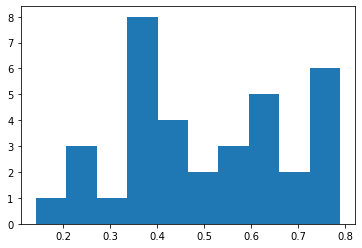

Time search : 17.145422805999942

Cross validation score :

roc_auc = 0.9404
precision 1 = 0.8966
recall 1 = 0.6903
f1 score 1 = 0.78

              precision    recall  f1-score   support

           0      0.848     0.956     0.899       205
           1      0.897     0.690     0.780       113

    accuracy                          0.862       318
   macro avg      0.873     0.823     0.840       318
weighted avg      0.866     0.862     0.857       318

Time validation : 0.7654592769999908

tf-idf+SGDClassifier Model : 

  Total time : 16.227 and n_iter : 26
Best parameters:  {'clf__alpha': 0.0003819283493119409, 'clf__loss': 'modified_huber', 'clf__penalty': 'l1', 'vect__text__reduce_dim': TruncatedSVD(algorithm='randomized', n_components=5, n_iter=5,
             random_state=None, tol=0.0), 'vect__text__tfidf__binary': True, 'vect__text__tfidf__lowercase': True, 'vect__text__tfidf__ngram_range': (1, 1), 'vect__text__tfidf__stop_words': None}
Mean cross-validated score of the bes

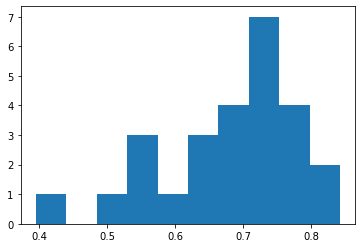

Time search : 16.412967346000073

Cross validation score :

roc_auc = 0.8906
precision 1 = 0.8364
recall 1 = 0.8142
f1 score 1 = 0.8251

              precision    recall  f1-score   support

           0      0.899     0.912     0.906       205
           1      0.836     0.814     0.825       113

    accuracy                          0.877       318
   macro avg      0.868     0.863     0.865       318
weighted avg      0.877     0.877     0.877       318

Time validation : 0.2807374810000738

tf-idf+Logistic_Regression Model : 

  Total time : 16.614 and n_iter : 12
Best parameters:  {'clf__C': 1.6799703693810315, 'clf__penalty': 'l1', 'vect__text__reduce_dim': TruncatedSVD(algorithm='randomized', n_components=10, n_iter=5,
             random_state=None, tol=0.0), 'vect__text__tfidf__binary': True, 'vect__text__tfidf__lowercase': True, 'vect__text__tfidf__ngram_range': (1, 2), 'vect__text__tfidf__stop_words': None}
Mean cross-validated score of the best_estimator:  0.8142


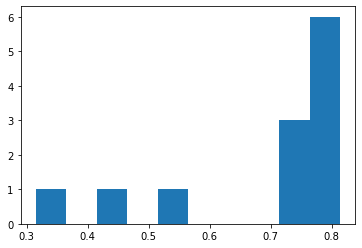

Time search : 16.811820848000025

Cross validation score :

roc_auc = 0.9396
precision 1 = 0.8788
recall 1 = 0.7699
f1 score 1 = 0.8208

              precision    recall  f1-score   support

           0      0.881     0.941     0.910       205
           1      0.879     0.770     0.821       113

    accuracy                          0.881       318
   macro avg      0.880     0.856     0.866       318
weighted avg      0.880     0.881     0.879       318

Time validation : 0.663481661999981

tf-idf+Naive_Bayes_ADJ_NOUN_VERB_DET Model : 

  Total time : 16.649 and n_iter : 35
Best parameters:  {'clf__alpha': 0.024147282530365244, 'vect__tfidf__binary': True, 'vect__tfidf__lowercase': True, 'vect__tfidf__ngram_range': (1, 3), 'vect__tfidf__stop_words': None}
Mean cross-validated score of the best_estimator:  0.7894


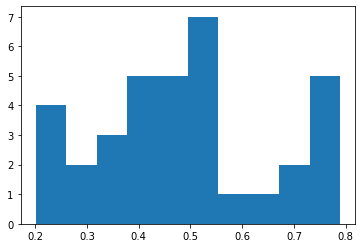

Time search : 16.84187788500003

Cross validation score :

roc_auc = 0.9441
precision 1 = 0.9195
recall 1 = 0.708
f1 score 1 = 0.8

              precision    recall  f1-score   support

           0      0.857     0.966     0.908       205
           1      0.920     0.708     0.800       113

    accuracy                          0.874       318
   macro avg      0.888     0.837     0.854       318
weighted avg      0.879     0.874     0.870       318

Time validation : 0.7967272060000141

tf-idf+SGDClassifier_ADJ_NOUN_VERB_DET Model : 

  Total time : 16.089 and n_iter : 14
Best parameters:  {'clf__alpha': 0.0018043988379587853, 'clf__loss': 'log', 'clf__penalty': 'l2', 'vect__text__reduce_dim': None, 'vect__text__tfidf__binary': True, 'vect__text__tfidf__lowercase': True, 'vect__text__tfidf__ngram_range': (1, 1), 'vect__text__tfidf__stop_words': None}
Mean cross-validated score of the best_estimator:  0.8384


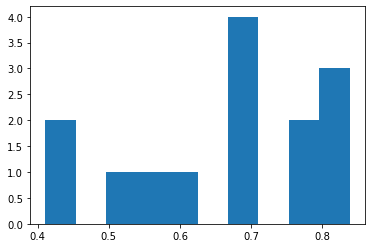

Time search : 16.386867926999912

Cross validation score :

roc_auc = 0.9651
precision 1 = 0.9362
recall 1 = 0.7788
f1 score 1 = 0.8502

              precision    recall  f1-score   support

           0      0.888     0.971     0.928       205
           1      0.936     0.779     0.850       113

    accuracy                          0.903       318
   macro avg      0.912     0.875     0.889       318
weighted avg      0.905     0.903     0.900       318

Time validation : 0.3010974589999478

tf-idf+Logistic_Regression_ADJ_NOUN_VERB_DET Model : 

  Total time : 16.275 and n_iter : 14
Best parameters:  {'clf__C': 2.2087715787138067, 'clf__penalty': 'l2', 'vect__text__reduce_dim': TruncatedSVD(algorithm='randomized', n_components=10, n_iter=5,
             random_state=None, tol=0.0), 'vect__text__tfidf__binary': True, 'vect__text__tfidf__lowercase': True, 'vect__text__tfidf__ngram_range': (1, 1), 'vect__text__tfidf__stop_words': True}
Mean cross-validated score of the best_estimator

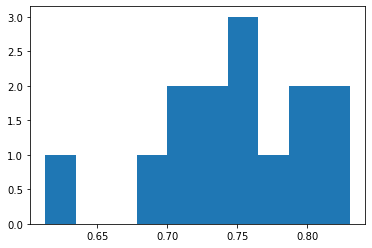

Time search : 16.457679666000104

Cross validation score :

roc_auc = 0.9475
precision 1 = 0.8692
recall 1 = 0.823
f1 score 1 = 0.8455

              precision    recall  f1-score   support

           0      0.905     0.932     0.918       205
           1      0.869     0.823     0.845       113

    accuracy                          0.893       318
   macro avg      0.887     0.877     0.882       318
weighted avg      0.892     0.893     0.892       318

Time validation : 0.24469925200014586

Fasttext_Attention Model : 

{'hidden_unit': 123, 'learning_rate': 0.001, 'dropout_rate': 0.4185569835345909}
oof_val score
f1
Metric
0.7837837837837838
  1%|          | 1/100 [01:01<1:42:00, 61.82s/trial, best loss: -0.7837837837837838]
Best parameters:  {'dropout_rate': 0.4185569835345909, 'hidden_unit': 123, 'learning_rate': 0.001}
Mean cross-validated score of the best_estimator:  0.7838

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


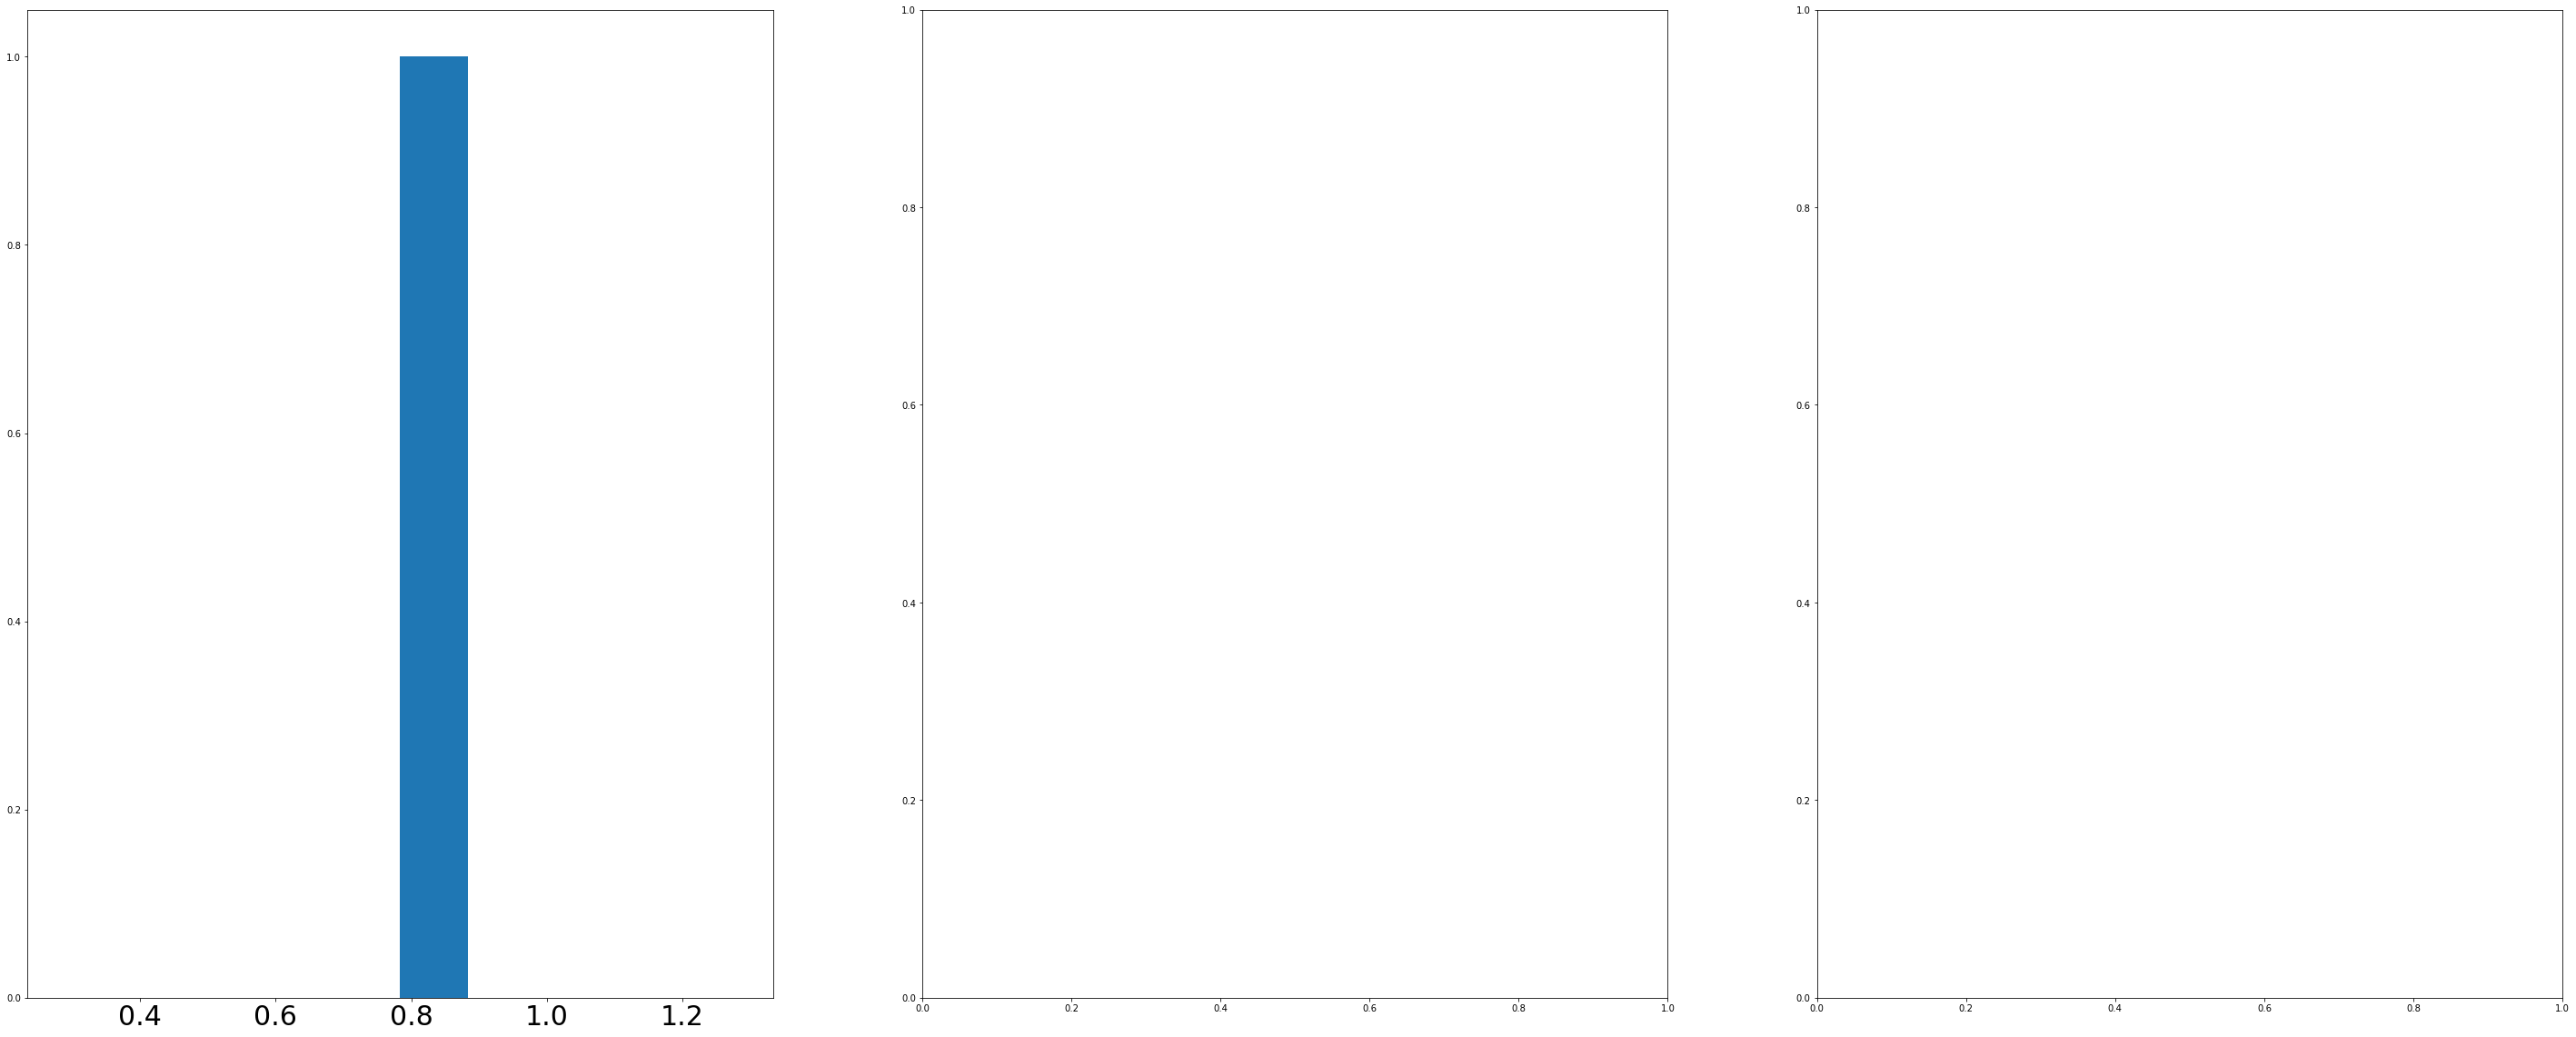

Time search : 73.55232290499998
Train on 254 samples, validate on 64 samples
Epoch 1/50
254/254 [==============================] - 4s 16ms/sample - loss: 0.6062 - accuracy: 0.7992 - val_loss: 0.5915 - val_accuracy: 0.7031
Epoch 2/50
254/254 [==============================] - 1s 3ms/sample - loss: 0.4834 - accuracy: 0.7835 - val_loss: 0.5766 - val_accuracy: 0.7344
Epoch 3/50
254/254 [==============================] - 1s 3ms/sample - loss: 0.3788 - accuracy: 0.8622 - val_loss: 0.5273 - val_accuracy: 0.7344
Epoch 4/50
254/254 [==============================] - 1s 3ms/sample - loss: 0.2361 - accuracy: 0.8858 - val_loss: 0.4999 - val_accuracy: 0.7969
Epoch 5/50
254/254 [==============================] - 1s 3ms/sample - loss: 0.1525 - accuracy: 0.9724 - val_loss: 0.4569 - val_accuracy: 0.8594
Epoch 6/50
254/254 [==============================] - 1s 3ms/sample - loss: 0.0487 - accuracy: 0.9803 - val_loss: 0.7619 - val_accuracy: 0.8438
Epoch 7/50
254/254 [==============================] - 1s 3


{'learning_rate': 0.0001, 'dropout_rate': 0.45660163788704444}
  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

oof_val score
f1
Metric
0.9557522123893806
  1%|          | 1/100 [05:52<9:41:46, 352.59s/trial, best loss: -0.9557522123893806]
Best parameters:  {'dropout_rate': 0.45660163788704444, 'learning_rate': 0.0001}
Mean cross-validated score of the best_estimator:  0.9558


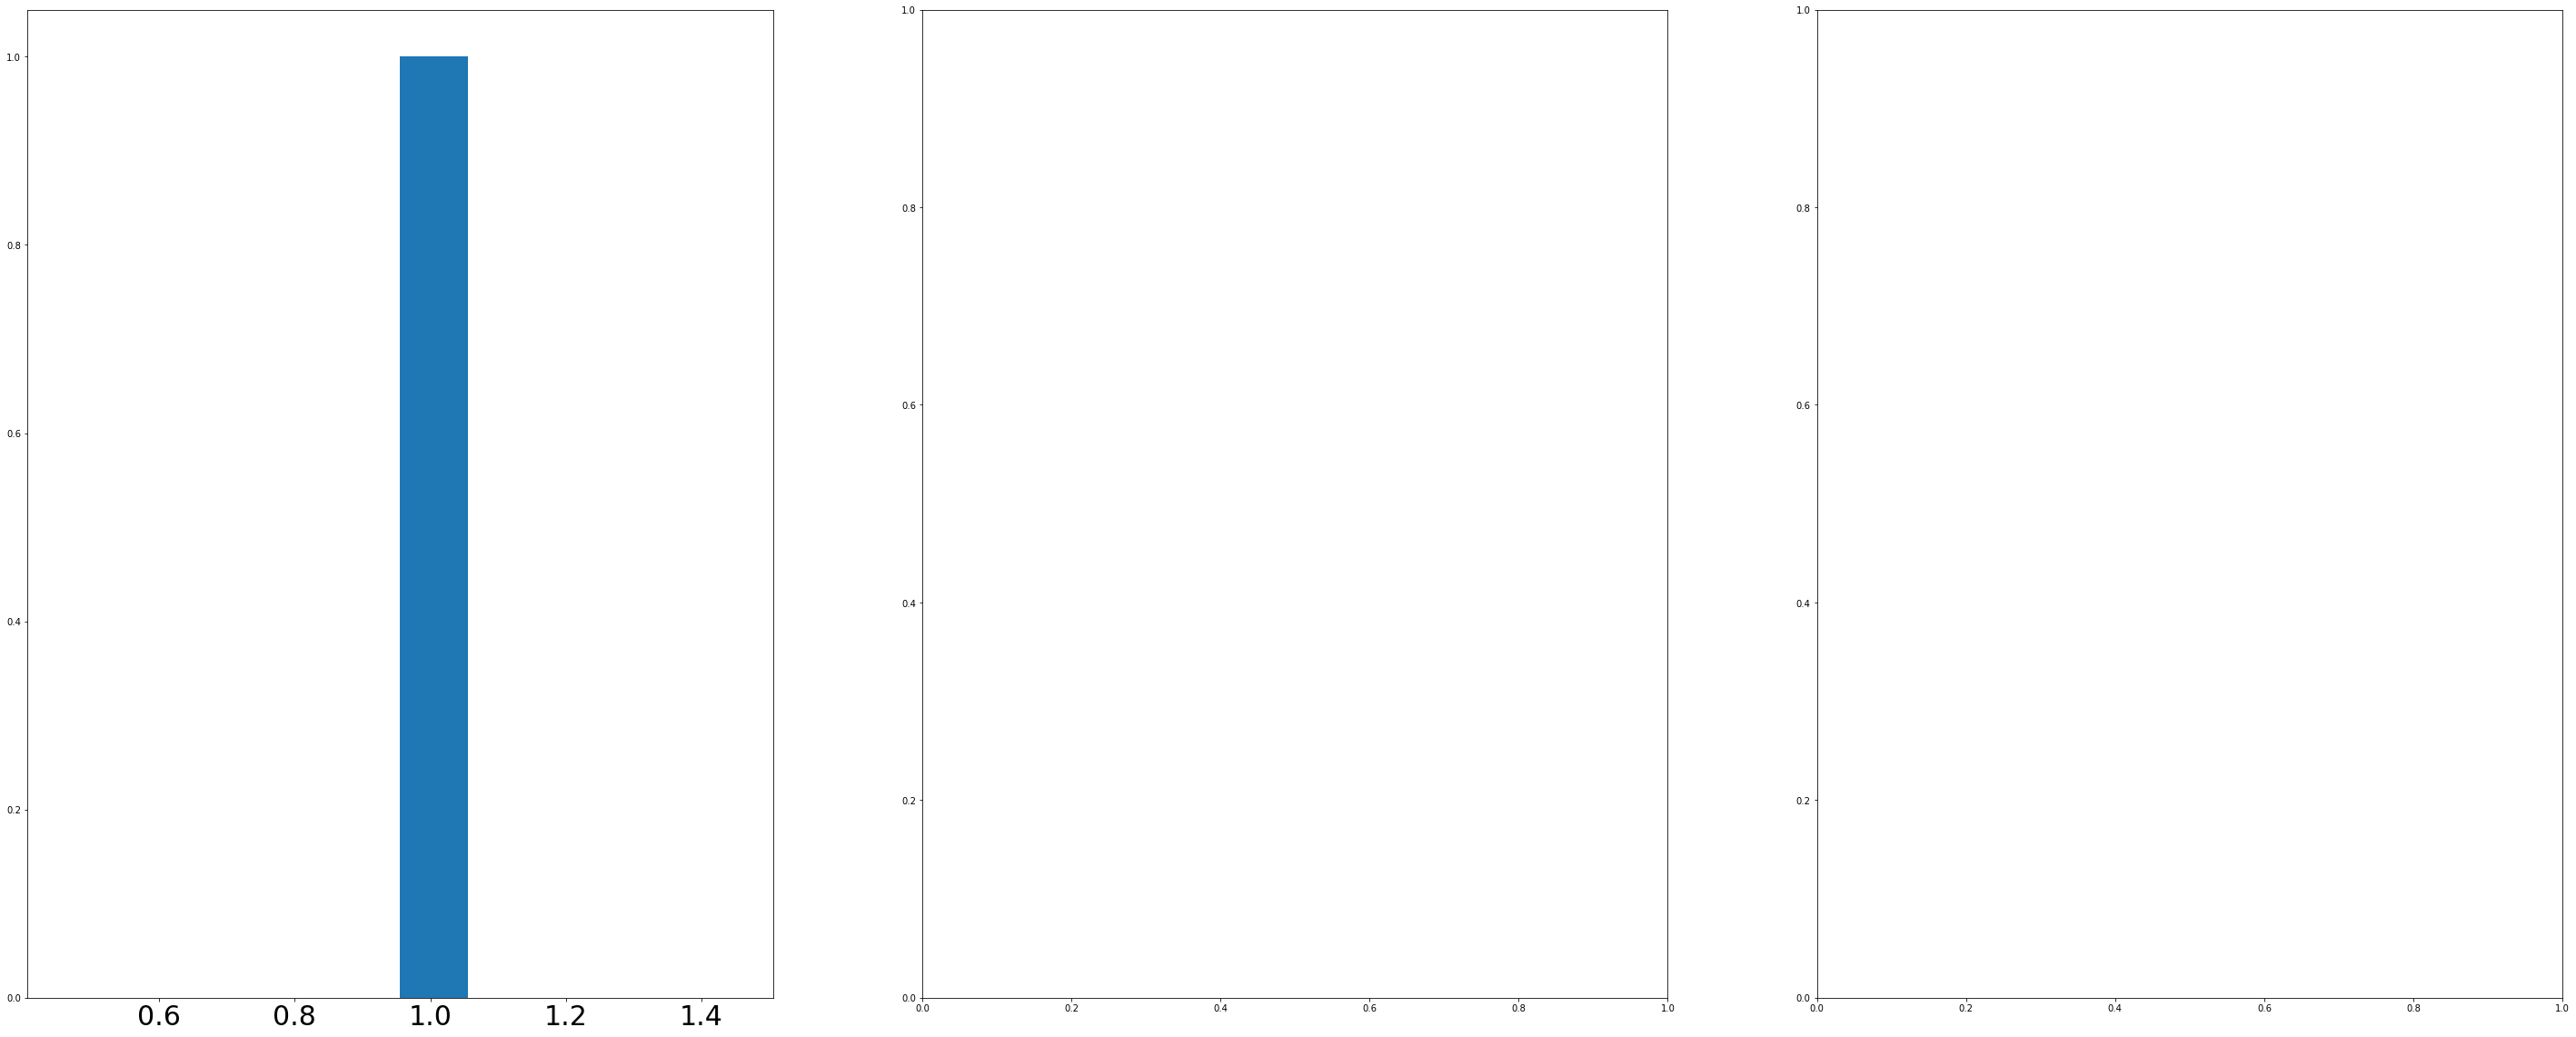

Time search : 455.643932599
Train on 254 samples, validate on 64 samples
Epoch 1/50
254/254 [==============================] - 25s 97ms/sample - loss: 0.4734 - accuracy: 0.7047 - val_loss: 0.3400 - val_accuracy: 0.8281
Epoch 2/50
254/254 [==============================] - 5s 19ms/sample - loss: 0.2312 - accuracy: 0.9291 - val_loss: 0.1452 - val_accuracy: 0.9375
Epoch 3/50
254/254 [==============================] - 5s 18ms/sample - loss: 0.0896 - accuracy: 0.9724 - val_loss: 0.0329 - val_accuracy: 1.0000
Epoch 4/50
254/254 [==============================] - 4s 17ms/sample - loss: 0.0556 - accuracy: 0.9882 - val_loss: 0.0707 - val_accuracy: 0.9844
Epoch 5/50
254/254 [==============================] - 4s 17ms/sample - loss: 0.0743 - accuracy: 0.9803 - val_loss: 0.2154 - val_accuracy: 0.9375
Epoch 6/50
254/254 [==============================] - 4s 17ms/sample - loss: 0.0596 - accuracy: 0.9843 - val_loss: 0.1192 - val_accuracy: 0.9531
Epoch 7/50
254/254 [==============================] - 5s

In [23]:
%%time
bml.train()

# Ensemble

In [24]:
%%time
bml.ensemble()


Blend Model : 


Cross validation score :

roc_auc = 0.9747
precision 1 = 0.9293
recall 1 = 0.8142
f1 score 1 = 0.8679

              precision    recall  f1-score   support

           0      0.904     0.966     0.934       205
           1      0.929     0.814     0.868       113

    accuracy                          0.912       318
   macro avg      0.917     0.890     0.901       318
weighted avg      0.913     0.912     0.910       318

CPU times: user 13.4 ms, sys: 3.2 ms, total: 16.6 ms
Wall time: 14 ms


# Leaderboard (Validation score)

In [25]:
bml.get_leaderboard(sort_by = sort_leaderboard, dataset = 'val')

,name,accuracy_val,recall_val,precision_val,f1_val,roc_auc_val
7,BERT,0.9780,0.9646,0.9732,0.9689,0.9924
8,BlendModel,0.9119,0.8142,0.9293,0.8679,0.9747
4,tf-idf+SGDClassifier_ADJ_NOUN_VERB_DET,0.9025,0.7788,0.9362,0.8502,0.9651
5,tf-idf+Logistic_Regression_ADJ_NOUN_VERB_DET,0.8931,0.8230,0.8692,0.8455,0.9475
1,tf-idf+SGDClassifier,0.8774,0.8142,0.8364,0.8251,0.8906
2,tf-idf+Logistic_Regression,0.8805,0.7699,0.8788,0.8208,0.9396
3,tf-idf+Naive_Bayes_ADJ_NOUN_VERB_DET,0.8742,0.7080,0.9195,0.8000,0.9441
6,Fasttext_Attention,0.8396,0.8142,0.7541,0.7830,0.8991
0,tf-idf+Naive_Bayes,0.8616,0.6903,0.8966,0.7800,0.9404


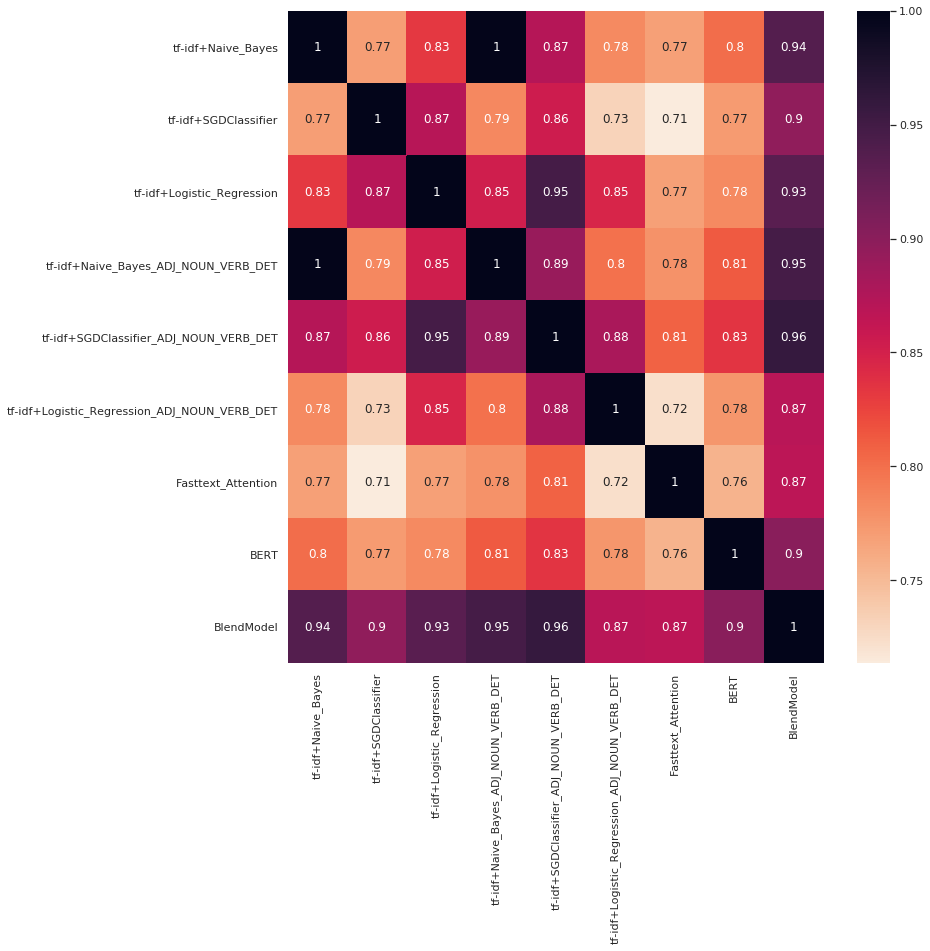

In [26]:
bml.correlation_models()

In [27]:
val_data = bml.Y_train
for name in bml.models.keys():
    val_data[name] = bml.models[name].info_scores['oof_val']
val_data.to_csv('oof_val.csv', index=False)
val_data

,sentiment,tf-idf+Naive_Bayes,tf-idf+SGDClassifier,tf-idf+Logistic_Regression,tf-idf+Naive_Bayes_ADJ_NOUN_VERB_DET,tf-idf+SGDClassifier_ADJ_NOUN_VERB_DET,tf-idf+Logistic_Regression_ADJ_NOUN_VERB_DET,Fasttext_Attention,BERT,BlendModel
353,0,0.000122,0.0,0.099361,0.001097,0.188635,0.293609,0.046054,0.021918,0.081349
21,1,0.697982,1.0,0.772521,0.623333,0.622192,0.507361,0.859127,0.964286,0.755850
216,1,0.198403,1.0,0.965169,0.317203,0.674599,0.569318,0.970949,0.992013,0.710957
67,1,0.985708,1.0,0.567272,0.947646,0.603759,0.499501,0.854588,0.990062,0.806067
131,0,0.009611,0.0,0.216857,0.016605,0.182552,0.317243,0.129504,0.049559,0.115241
...,...,...,...,...,...,...,...,...,...,...
169,1,0.999450,1.0,0.995902,0.998243,0.837827,0.707882,0.973689,0.991786,0.938097
180,0,0.024689,1.0,0.457090,0.054078,0.438254,0.431055,0.955840,0.068047,0.428632
327,0,0.000025,0.0,0.151052,0.000278,0.203365,0.316694,0.019489,0.037193,0.091012
231,1,0.671657,1.0,0.614019,0.608091,0.598501,0.513593,0.689100,0.985304,0.710033


In [28]:
df_all_results = bml.get_df_all_results()
df_all_results.to_csv('df_all_results.csv', index=False)
df_all_results.head()

,mean_fit_time,params,mean_test_score,std_test_score,model
0,0.165518,"{'clf__alpha': 0.010858632208117225, 'vect__tf...",0.788670,0.065010,tf-idf+Naive_Bayes
1,0.030724,"{'clf__alpha': 0.02241342334411256, 'vect__tfi...",0.770934,0.080015,tf-idf+Naive_Bayes
2,0.126142,"{'clf__alpha': 0.0190898939976879, 'vect__tfid...",0.764711,0.099254,tf-idf+Naive_Bayes
3,0.031880,"{'clf__alpha': 0.07858183342607439, 'vect__tfi...",0.744425,0.061235,tf-idf+Naive_Bayes
4,0.073562,"{'clf__alpha': 0.002543633972716064, 'vect__tf...",0.736257,0.058164,tf-idf+Naive_Bayes


In [29]:
df_all_results.groupby('model').mean().sort_values('mean_test_score', ascending = False)

,mean_fit_time,mean_test_score,std_test_score
model,,,
BERT,352.578591,0.955752,0.000000
Fasttext_Attention,61.812427,0.783784,0.000000
tf-idf+Logistic_Regression_ADJ_NOUN_VERB_DET,0.207064,0.750717,0.061248
tf-idf+Logistic_Regression,0.244041,0.689007,0.095527
tf-idf+SGDClassifier,0.101387,0.685236,0.120557
tf-idf+SGDClassifier_ADJ_NOUN_VERB_DET,0.195828,0.666644,0.125695
tf-idf+Naive_Bayes,0.076020,0.503581,0.071716
tf-idf+Naive_Bayes_ADJ_NOUN_VERB_DET,0.074818,0.484763,0.075552


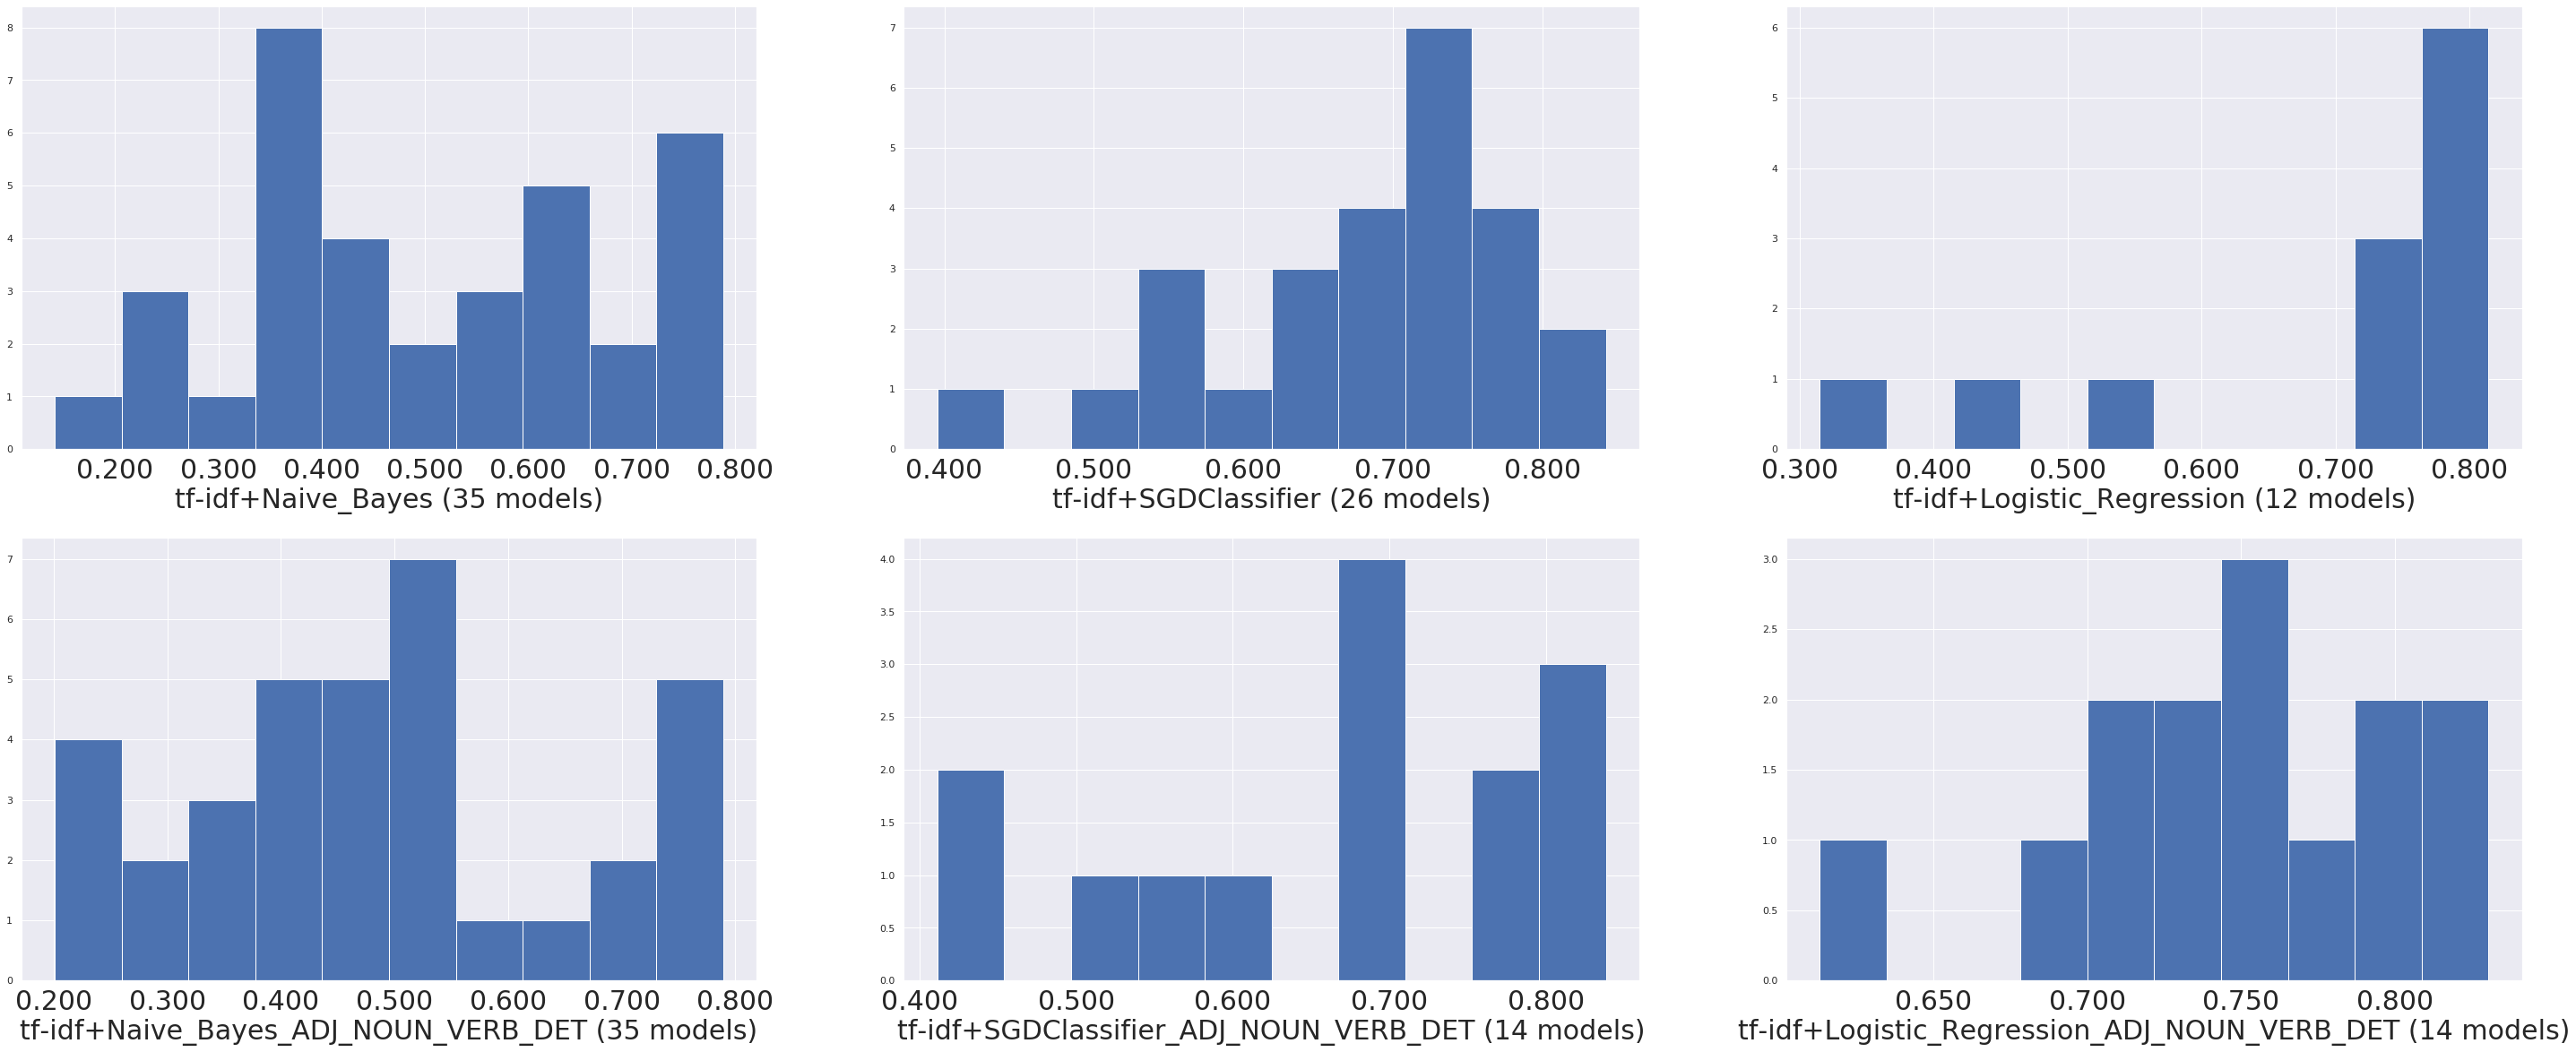

In [30]:
bml.show_distribution_scores()

In [31]:
if bml.objective == 'binary_proba':
    bml.get_roc_curves()

In [32]:
on_test_data = True
bml.leader_predict(on_test_data)    # or bml.leader_predict(aml.X_test, aml.Y_test)

In [33]:
prediction = bml.dataframe_predictions
prediction.to_csv('prediction.csv', index=False)
prediction

,y_true,tf-idf+Naive_Bayes,tf-idf+SGDClassifier,tf-idf+Logistic_Regression,tf-idf+Naive_Bayes_ADJ_NOUN_VERB_DET,tf-idf+SGDClassifier_ADJ_NOUN_VERB_DET,tf-idf+Logistic_Regression_ADJ_NOUN_VERB_DET,Fasttext_Attention,BERT,BlendModel
0,1,0.004,0.0,0.380,0.016,0.439,0.461,0,0,0.163
1,0,0.033,0.0,0.205,0.055,0.411,0.463,0,0,0.146
2,0,0.001,0.0,0.297,0.005,0.253,0.544,0,0,0.138
3,1,0.914,1.0,0.934,0.892,0.812,0.774,0,0,0.666
4,0,0.079,0.0,0.416,0.115,0.430,0.369,0,0,0.176
...,...,...,...,...,...,...,...,...,...,...
75,0,0.000,0.0,0.071,0.000,0.110,0.185,0,0,0.046
76,0,0.000,0.0,0.077,0.000,0.149,0.253,0,0,0.060
77,0,0.000,0.0,0.081,0.000,0.192,0.327,0,0,0.075
78,0,0.005,0.0,0.182,0.013,0.270,0.487,0,0,0.120


In [34]:
prediction.corr()

,y_true,tf-idf+Naive_Bayes,tf-idf+SGDClassifier,tf-idf+Logistic_Regression,tf-idf+Naive_Bayes_ADJ_NOUN_VERB_DET,tf-idf+SGDClassifier_ADJ_NOUN_VERB_DET,tf-idf+Logistic_Regression_ADJ_NOUN_VERB_DET,Fasttext_Attention,BERT,BlendModel
y_true,1.000000,0.719509,0.660029,0.756974,0.730114,0.743431,0.652163,NaN,NaN,0.766816
tf-idf+Naive_Bayes,0.719509,1.000000,0.738960,0.833167,0.996196,0.854173,0.735198,NaN,NaN,0.938810
tf-idf+SGDClassifier,0.660029,0.738960,1.000000,0.844859,0.761530,0.807417,0.691150,NaN,NaN,0.890576
tf-idf+Logistic_Regression,0.756974,0.833167,0.844859,1.000000,0.862281,0.940005,0.824847,NaN,NaN,0.950222
tf-idf+Naive_Bayes_ADJ_NOUN_VERB_DET,0.730114,0.996196,0.761530,0.862281,1.000000,0.880527,0.763418,NaN,NaN,0.955746
tf-idf+SGDClassifier_ADJ_NOUN_VERB_DET,0.743431,0.854173,0.807417,0.940005,0.880527,1.000000,0.880115,NaN,NaN,0.952428
tf-idf+Logistic_Regression_ADJ_NOUN_VERB_DET,0.652163,0.735198,0.691150,0.824847,0.763418,0.880115,1.000000,NaN,NaN,0.850787
Fasttext_Attention,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BERT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BlendModel,0.766816,0.938810,0.890576,0.950222,0.955746,0.952428,0.850787,NaN,NaN,1.000000


In [35]:
leaderboard_test = bml.get_leaderboard(sort_by = sort_leaderboard, dataset = 'test')
leaderboard_test.to_csv('leaderboard_test.csv', index=False)
leaderboard_test

,name,accuracy_test,recall_test,precision_test,f1_test,roc_auc_test
4,tf-idf+SGDClassifier_ADJ_NOUN_VERB_DET,0.8625,0.7500,0.7826,0.7660,0.9435
3,tf-idf+Naive_Bayes_ADJ_NOUN_VERB_DET,0.8750,0.6667,0.8889,0.7619,0.9397
2,tf-idf+Logistic_Regression,0.8625,0.7083,0.8095,0.7556,0.9464
1,tf-idf+SGDClassifier,0.8625,0.6667,0.8421,0.7442,0.8229
5,tf-idf+Logistic_Regression_ADJ_NOUN_VERB_DET,0.8500,0.6667,0.8000,0.7273,0.9003
0,tf-idf+Naive_Bayes,0.8500,0.6250,0.8333,0.7143,0.9308
8,BlendModel,0.8375,0.5000,0.9231,0.6486,0.9531
6,Fasttext_Attention,0.7000,0.0000,0.0000,0.0000,0.5000
7,BERT,0.7000,0.0000,0.0000,0.0000,0.5000


In [36]:
leaderboard_val = bml.get_leaderboard(sort_by = sort_leaderboard, dataset = 'val')
leaderboard_val.to_csv('leaderboard_val.csv', index=False)
leaderboard_val

,name,accuracy_val,recall_val,precision_val,f1_val,roc_auc_val
7,BERT,0.9780,0.9646,0.9732,0.9689,0.9924
8,BlendModel,0.9119,0.8142,0.9293,0.8679,0.9747
4,tf-idf+SGDClassifier_ADJ_NOUN_VERB_DET,0.9025,0.7788,0.9362,0.8502,0.9651
5,tf-idf+Logistic_Regression_ADJ_NOUN_VERB_DET,0.8931,0.8230,0.8692,0.8455,0.9475
1,tf-idf+SGDClassifier,0.8774,0.8142,0.8364,0.8251,0.8906
2,tf-idf+Logistic_Regression,0.8805,0.7699,0.8788,0.8208,0.9396
3,tf-idf+Naive_Bayes_ADJ_NOUN_VERB_DET,0.8742,0.7080,0.9195,0.8000,0.9441
6,Fasttext_Attention,0.8396,0.8142,0.7541,0.7830,0.8991
0,tf-idf+Naive_Bayes,0.8616,0.6903,0.8966,0.7800,0.9404


# Extraction of influent words

In [37]:
import tensorflow as tf
from tensorflow.keras import backend as K
import numpy as np
from IPython.core.display import display, HTML

def attention_weight(x, fixed_weights_attention, biais_attention, step_dim):
    """ refaire les calculs effectuer dans la couche attention pour obtenir les poids"""
    """ fixed_weights_attention (array) : Weight fixe de la couche attention appris
        biais_attention (array) : biais de la couche attention appris
        step_dim (int) : maxlen"""
    """ return : weights (array)"""

    features_dim = fixed_weights_attention.shape[0]

    eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                          K.reshape(fixed_weights_attention, (features_dim, 1))), (-1, step_dim))

    eij += biais_attention

    eij = K.tanh(eij)

    a = K.exp(eij)

    a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

    weights = K.expand_dims(a)
    # weighted_input = x * a
    return weights

In [38]:
def extract_influent_word(bml, type_data, n_influent_word, pr):
    if 'binary_proba' in bml.objective:
        print(" Extraction doesn't work with objective = binary_proba ")
        return None

    if type_data == 'train':
        X = bml.X_train.copy()
        Y = bml.Y_train.copy()
    else:
        X = bml.X_test.copy()
        Y = bml.Y_test.copy()

    dataset = X.iloc[:, bml.column_text].copy().reset_index(drop=True)
    target = Y[bml.target[0]].copy().reset_index(drop=True)

    # tokenize for FastText
    if 'Fasttext_Attention' in bml.models.keys():
        token_d = bml.models['Fasttext_Attention'].preprocessing_transform(X)['tok']

        fixed_weights_attention = bml.models['Fasttext_Attention'].best_model.layers[-2].get_weights()[0]
        features_dim = fixed_weights_attention.shape[0]
        biais_attention = bml.models['Fasttext_Attention'].best_model.layers[-2].get_weights()[1]

        # Extraction Model
        extract_model_fasttext_attention = tf.keras.Model(inputs=bml.models['Fasttext_Attention'].best_model.input,
                                                          outputs=(
                                                          bml.models['Fasttext_Attention'].best_model.layers[-4].output,
                                                          bml.models['Fasttext_Attention'].best_model.layers[-1].output))

    if 'BERT' in bml.models.keys():
        x_preprocessed = bml.models['BERT'].preprocessing_transform(X)
        ids_d = x_preprocessed[0]
        att_d = x_preprocessed[1]
        tok_d = x_preprocessed[2]
        # cha_d = cha

        all_layer_weights_camembert = bml.models['BERT'].best_model.layers[-1].get_weights()[0]
        extract_model_camembert = tf.keras.Model(inputs=bml.models['BERT'].best_model.input,
                                                 outputs=(bml.models['BERT'].best_model.layers[-4].output,
                                                          bml.models['BERT'].best_model.layers[-1].output))

    html = ''
    for k in range(50):

        if len(dataset[k]) > 500: continue  # trop large à afficher

        list_pred = []
        if 'Fasttext_Attention' in bml.models.keys():
            # EXTRACT MODEL
            embedding_output, pred_vec = extract_model_fasttext_attention.predict([token_d[k:k + 1]])
            embedding_output = np.squeeze(embedding_output[0])  # dim (MAX_LEN,256)
            pred = np.argmax(pred_vec)
            list_pred.append(pred)
            weights_attention = attention_weight(embedding_output, fixed_weights_attention, biais_attention,
                                                 bml.models['Fasttext_Attention'].maxlen)
            weights_attention = np.squeeze(weights_attention[0])

        if 'BERT' in bml.models.keys():
            embedding_output_3, pred_vec_3 = extract_model_camembert.predict(
                [ids_d[k:k + 1, :], att_d[k:k + 1, :], tok_d[k:k + 1, :]])
            embedding_output_3 = np.squeeze(embedding_output_3[0])  # dim (MAX_LEN,768)
            pred_3 = np.argmax(pred_vec_3)
            list_pred.append(pred_3)
            layer_weights_3 = all_layer_weights_camembert[:, pred_3]
            final_output_3 = np.dot(embedding_output_3, layer_weights_3)

        if target[k] not in list_pred: continue  # ne pas afficher les mal classés

        # DISPLAY TEXT
        # html = ''
        info = 'Train row %i. Predict %s.   True label is %s' % (k, target[k], target[k])
        html += info + '<br><br>'

        if 'Fasttext_Attention' in bml.models.keys():
            idx = list(token_d[k:k + 1][0]).count(0)
            nb_tok = bml.models['Fasttext_Attention'].maxlen - idx
            if nb_tok < n_influent_word * 2:
                n_influent_word__ = int(nb_tok / 2)
            else:
                n_influent_word__ = n_influent_word

            weights_attention = weights_attention[:-idx]
            v = np.argsort(weights_attention)
            mx = weights_attention[v[-1]];
            x = max(-n_influent_word, -len(v))
            mn = weights_attention[v[x]]

            html += '<b>Attention &emsp;&nbsp;:</b>'
            if pred == target[k]:
                list_ = []
                for j in range(len(weights_attention)):
                    x = (weights_attention[j] - mn) / (mx - mn)
                    list_.append(x)
                g = list(np.argsort(list_))[::-1]
                for j in range(len(weights_attention)):
                    if j in g[:n_influent_word__]:
                        x = 1 - g.index(j) * 0.7 / n_influent_word
                    else:
                        x = 0

                    html += ' '
                    html += "<span style='background:{};font-family:monospace'>".format('rgba(255,255,0,%f)' % x)
                    html += bml.models['Fasttext_Attention'].tokenizer.sequences_to_texts(token_d[k:k + 1, j:j + 1])[0]
                    html += "</span>"
            html += "<br>"

        if 'BERT' in bml.models.keys():
            idx = np.sum(att_d[k,])
            if idx < n_influent_word * 2:
                n_influent_word__ = int(idx / 2)
            else:
                n_influent_word__ = n_influent_word

            ## technique 3
            v = np.argsort(final_output_3[:idx - 1])
            mx = final_output_3[v[-1]];
            x = max(-n_influent_word, -len(v))
            mn = final_output_3[v[x]]

            # DISPLAY TEXT
            html += '<b>Camembert :</b>'
            tokenize = bml.models['BERT'].tokenizer.tokenize(bml.models['BERT'].tokenizer.decode(ids_d[k]))
            list_ = []
            if pred_3 == target[k]:
                for j in range(1, idx):
                    x = (final_output_3[j] - mn) / (mx - mn)
                    list_.append(x)
                g = list(np.argsort(list_))[::-1]
                for j in range(1, idx):
                    if j - 1 in g[:n_influent_word__]:
                        x = 1 - g.index(j - 1) * 0.7 / n_influent_word
                    else:
                        x = 0
                    if tokenize[j][0] == '▁':
                        html += ' '
                    html += "<span style='background:{};font-family:monospace'>".format('rgba(255,255,0,%f)' % x)
                    html += bml.models['BERT'].tokenizer.decode([ids_d[k, j]])
                    html += "</span>"
            html += "<br>"

        html += '<br><br><br>'
    display(HTML(html))

In [39]:
pr = {0: 'NEGATIVE', 1: 'POSITIVE'}
n_influent_word = 10
type_data = 'train'  # 'test'

In [40]:
if 'Fasttext_Attention' in bml.models.keys() or 'BERT' in bml.models.keys():
    extract_influent_word(bml, type_data, n_influent_word, pr)

 Extraction doesn't work with objective = binary_proba 
